In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
from multiprocessing import Process
import random
from feature_selection import feature_ranking_algorithm
import time

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "./RFLFSODataFull.csv"
root_dir = "./"


In [3]:
def load_data():
    df = pd.read_csv(data_path)
    return df

original_data = load_data()

<Figure size 1200x1200 with 0 Axes>

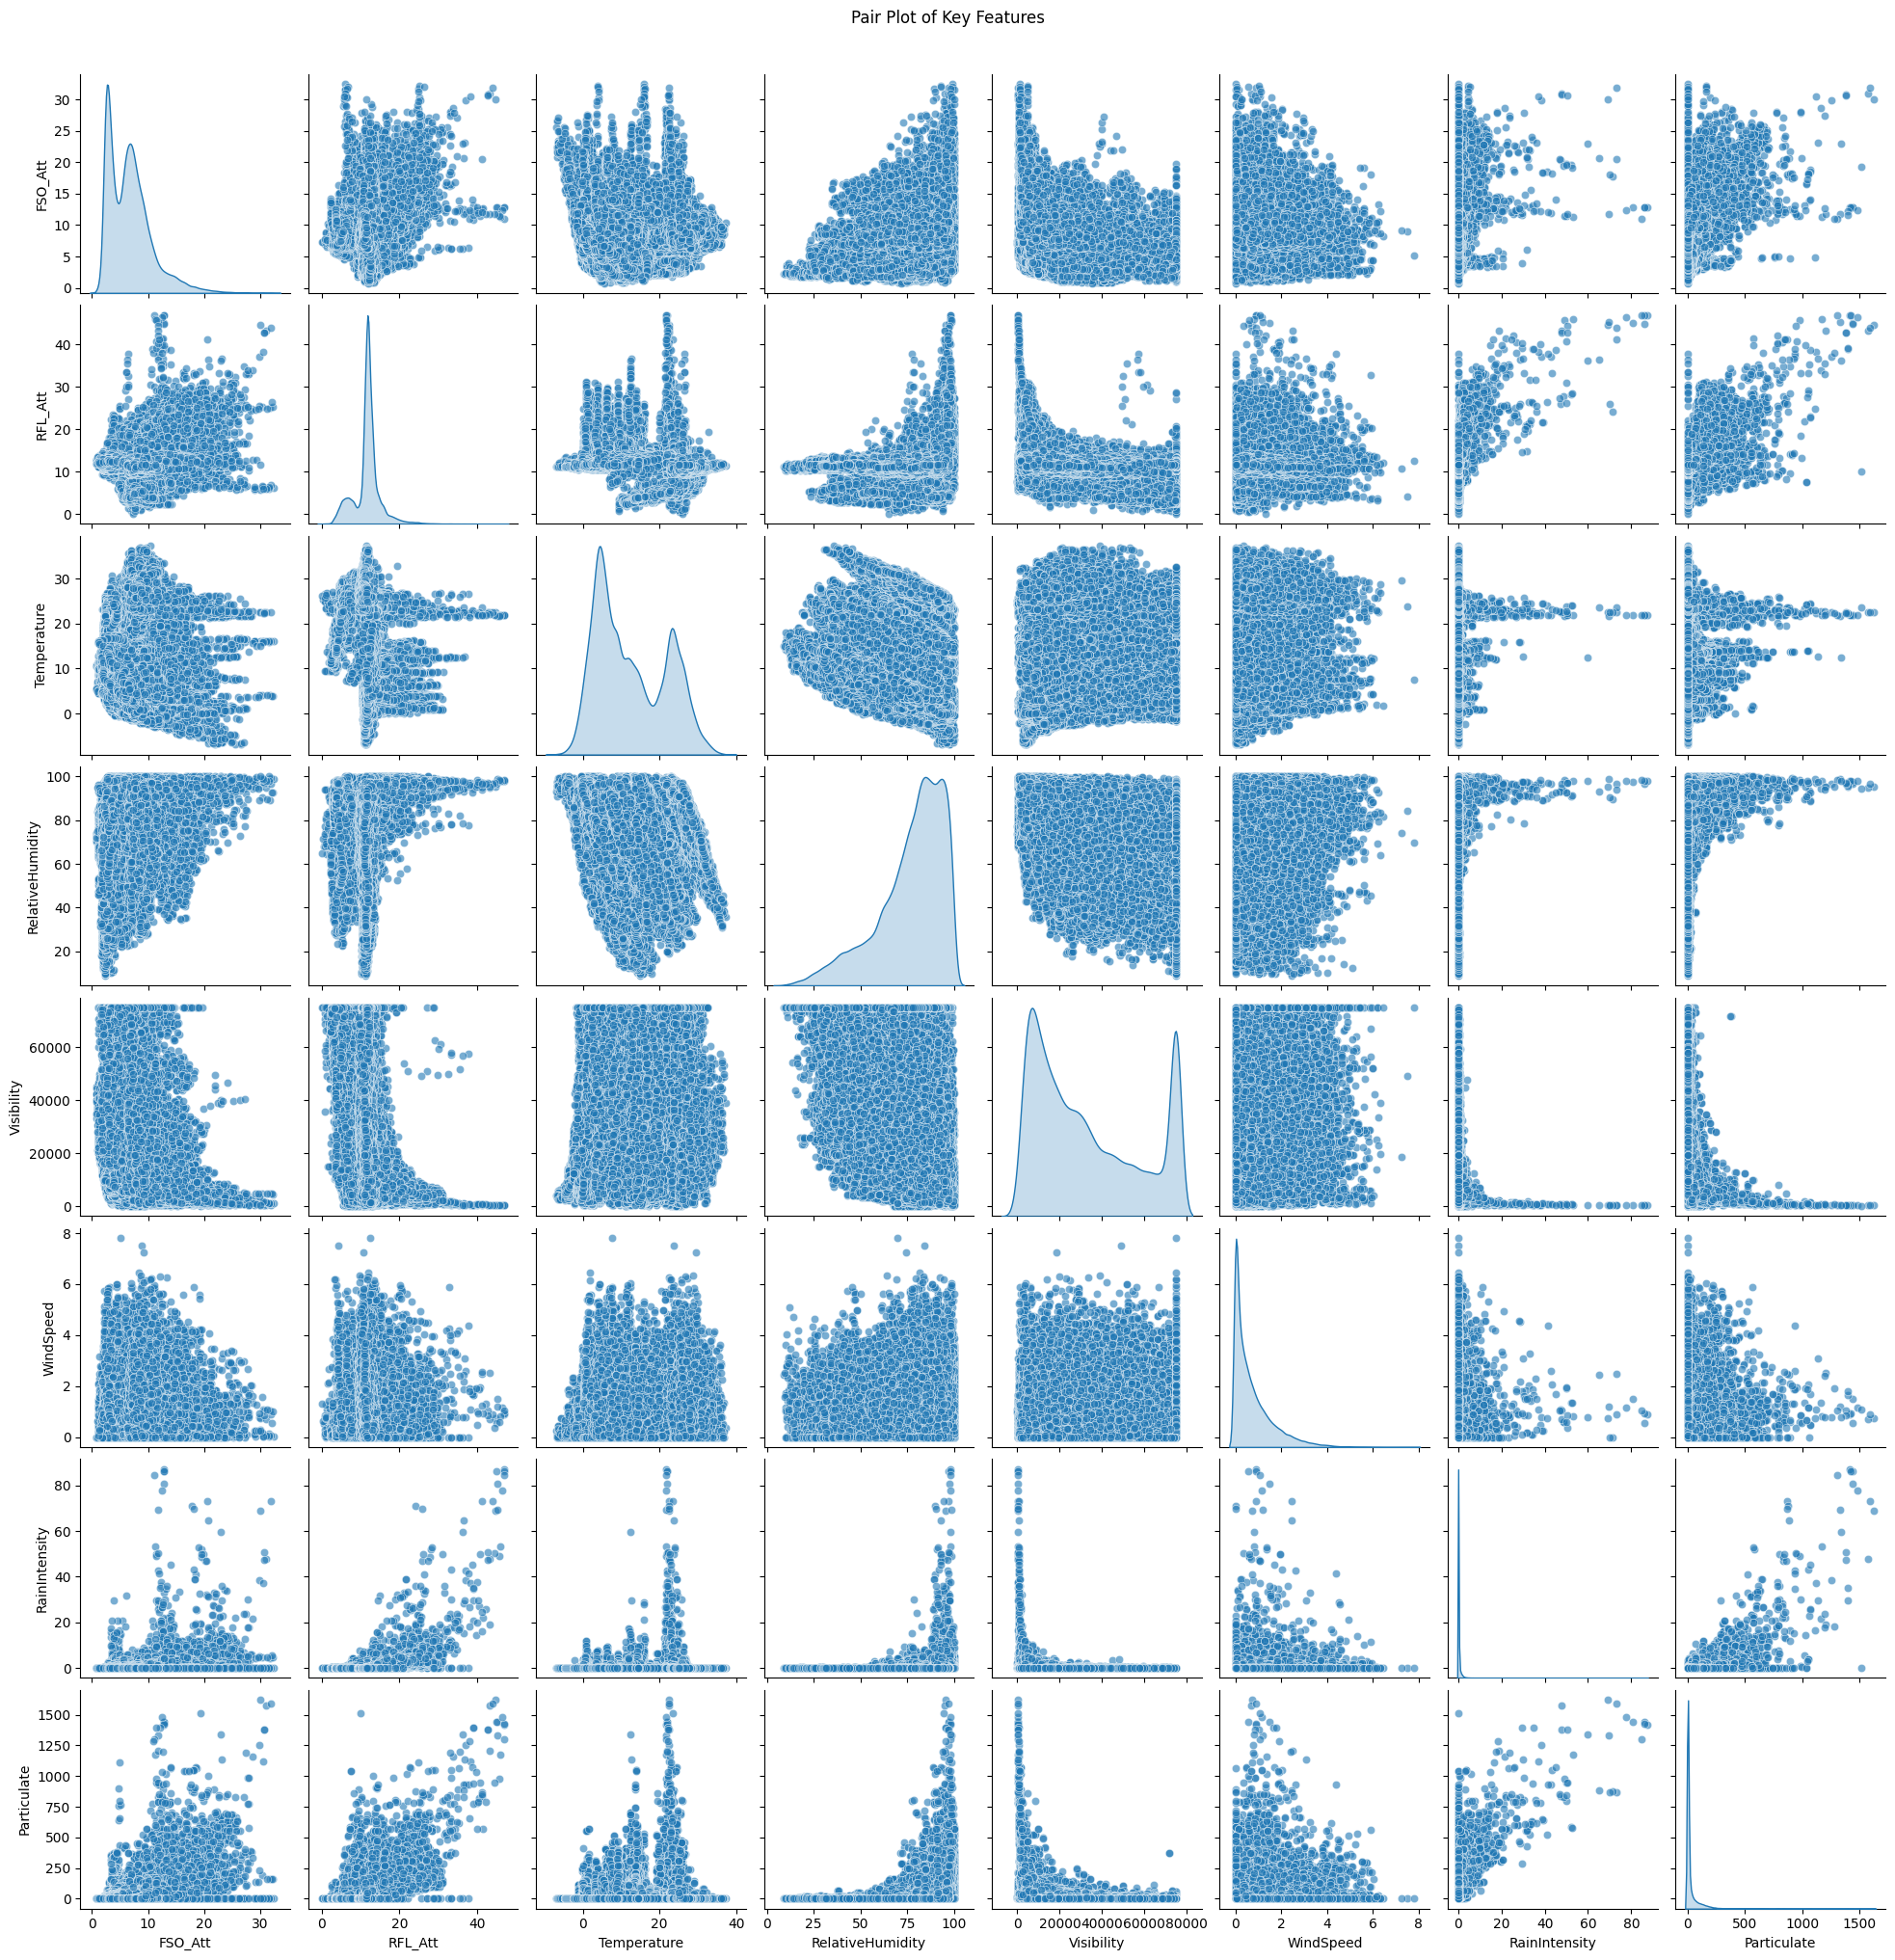

In [4]:
# select key variables
key_features = [
    'FSO_Att', 'RFL_Att', 
    'Temperature', 'RelativeHumidity',
    'Visibility', 'WindSpeed',
    'RainIntensity', 'Particulate'
]

# create pairplot
plt.figure(figsize=(12, 12))
sns.pairplot(
    data=original_data[key_features],
    diag_kind='kde',  
    plot_kws={'alpha': 0.6}, 
)
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.show()

In [107]:
processed_data = original_data.copy()

# Time: directly convert to category type
processed_data['Time'] = processed_data['Time'].astype('category')

# SYNOPCode: directly convert to category type
processed_data['SYNOPCode'] = processed_data['SYNOPCode'].astype('category')

# Frequency: convert to GHz unit
processed_data['Frequency'] = processed_data['Frequency'] / 1e9
print(processed_data.dtypes)


# prepare feature set (remove target variables)
feature_cols = [col for col in processed_data.columns 
               if col not in ['FSO_Att', 'RFL_Att']]

FSO_Att                   float64
RFL_Att                   float64
AbsoluteHumidity          float64
AbsoluteHumidityMax       float64
AbsoluteHumidityMin       float64
Distance                  float64
Frequency                 float64
Particulate               float64
ParticulateMax            float64
ParticulateMin            float64
RainIntensity             float64
RainIntensityMax          float64
RainIntensityMin          float64
RelativeHumidity          float64
SYNOPCode                category
Temperature               float64
TemperatureDifference     float64
TemperatureMax            float64
TemperatureMin            float64
Time                     category
Visibility                float64
VisibilityMax             float64
VisibilityMin             float64
WindDirection             float64
WindSpeed                 float64
WindSpeedMax              float64
WindSpeedMin              float64
dtype: object


In [108]:
# def split_data(df, feature_cols, test_size=0.2, random_state=42):
#     X = df[feature_cols]
#     y_rfl = df['RFL_Att']
#     y_fso = df['FSO_Att']
    
#     # sampling by SYNOPCode 
#     X_train, X_test, y_rfl_train, y_rfl_test, y_fso_train, y_fso_test = train_test_split(
#         X, y_rfl, y_fso, test_size=test_size, random_state=random_state, stratify=df['SYNOPCode']
#     )
    
#     # check SYNOPCode 1d Series
#     synop_train = df.loc[X_train.index, 'SYNOPCode'].reset_index(drop=True)
#     synop_test = df.loc[X_test.index, 'SYNOPCode'].reset_index(drop=True)
    
#     # reconstruct df
#     train_df = pd.concat([
#         X_train.reset_index(drop=True), 
#         y_rfl_train.rename('RFL_Att').reset_index(drop=True), 
#         y_fso_train.rename('FSO_Att').reset_index(drop=True)
#     ], axis=1)
    
#     test_df = pd.concat([
#         X_test.reset_index(drop=True), 
#         y_rfl_test.rename('RFL_Att').reset_index(drop=True), 
#         y_fso_test.rename('FSO_Att').reset_index(drop=True)
#     ], axis=1)

#     return train_df, test_df

In [109]:
def plot_feature_selection_results(results_df, title, divide_feature, save_path=None):
    """
    plot the feature selection process
    
    Parameters:
    -----------
    results_df : DataFrame
        the dataframe containing the feature selection results
    title : str
        the title of the image
    save_path : str, optional
        if provided, save the image to the specified path
    """
    fig, ax1 = plt.subplots(figsize=(7, 5))
    ax2 = ax1.twinx()

    # plot RMSE (blue line, left axis)
    line1 = ax1.plot(range(len(results_df)), 
                     results_df['oob_rmse'], 
                     color='blue', 
                     marker='o', 
                     label='RMSE')
    ax1.set_xlabel('Removed Features')
    ax1.set_ylabel('RMSE', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # plot R² (red line, right axis)
    line2 = ax2.plot(range(len(results_df)), 
                     results_df['oob_r2'], 
                     color='red', 
                     marker='o', 
                     label='R²')
    ax2.set_ylabel('R² Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')


    ax1.set_xticks(range(len(results_df)))
    ax1.set_xticklabels(results_df['removed_feature'], rotation=90, ha='center')

    # find the position of Time and add a vertical line
    time_idx = results_df[results_df['removed_feature'] == divide_feature].index[0]
    ax1.axvline(x=time_idx - 0.5,  # subtract 0.5 from x value !!
                color='green', 
                linestyle='--',
                linewidth=2,
                alpha=0.8,
                label='Time Position')

    lines = line1 + line2 + [ax1.get_lines()[-1]]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.title(title)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()





def load_and_plot_single_result(target_type, synop_code, divide_feature, method='method1'):
    """
    load and plot the feature selection results for a single SYNOP group
    
    Parameters:
    -----------
    target_type : str
        'RFL' 或 'FSO'
    synop_code : str or int
        the code of the SYNOP group
    """
    # result directory and file
    result_dir = f'results_{target_type.lower()}'
    result_file = f'synop_{synop_code}_results.pkl'
    
    # load results
    with open(os.path.join(result_dir, result_file), 'rb') as f:
        results_df = pickle.load(f)

    results_df = results_df.sort_index()
    # print(results_df)
    
    # create image title
    title = f'Feature Selection Results for SYNOP {synop_code} ({target_type})'
    
    save_path = os.path.join(result_dir, f'{target_type.lower()}_{method}_{synop_code}.png')
    
    plot_feature_selection_results(results_df, title, divide_feature, save_path)

    features_at_divide = results_df.loc[results_df['removed_feature'] == divide_feature, 'features'].values[0]

    
    return features_at_divide


In [110]:
def gene_final_X_y(important_features, target_type, synop_code=None):
    if synop_code is None:
        # actually, method2
        group_data = processed_data
    else:
        # actually, method1
        group_data = processed_data[processed_data['SYNOPCode'] == synop_code]
    
    X = group_data[important_features]
    y = group_data[target_type]
    return X, y


In [111]:
# mutual_info & confusion_matrix
def calculate_mutual_info_continuous_discretize(y, ypred, bins=20):
    # Compute a 2D frequency matrix (for visualization)
    cm, y_edges, ypred_edges = np.histogram2d(y, ypred, bins=bins)

    # Discretize each sample according to the boundary (note that digitize inputs samples and returns bin numbers)
    y_binned = np.digitize(y, y_edges) - 1  # -1 是因为 digitize 从1开始编号
    ypred_binned = np.digitize(ypred, ypred_edges) - 1

    # Ensure that the bin number falls within the legal range
    y_binned = np.clip(y_binned, 0, bins-1)
    ypred_binned = np.clip(ypred_binned, 0, bins-1)

    # Calculating mutual information
    mutual_info = mutual_info_score(y_binned, ypred_binned)

    return mutual_info, cm, y_edges, ypred_edges

In [112]:
from sklearn.metrics import make_scorer
def tune_random_forest(X, y, param_grid=None, cv=5, verbose=True, bins=20):
    """
    tune the hyperparameters of the random forest model
    
    Parameters:
    -----------
    X : feature data
    y : target variable
    param_grid : hyperparameter grid, if None, use the default grid
    cv : number of cross-validation folds
    verbose : whether to print detailed information
    
    Returns:
    --------
    dict : a dictionary containing the best model and performance metrics
    """
    # if param_grid is None, use the default grid
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 150],
            'max_depth': [None, 10, 20]
        }
    
    if verbose:
        print("Start tuning...")
        print(f"Dataset size: {X.shape}")
        print("Parameter grid:", param_grid)
        print("\n" + "-"*80)
        print(f"{'n_estimators':>12} | {'max_depth':>9} | {'OOB Score':>9} | {'OOB R²':>9} | {'OOB RMSE':>9} | {'OOB mutualinfo':>9}")
        print("-"*80)

    results = []


    # nested loop to iterate through all parameter combinations
    for n_trees in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            # train model
            rf = RandomForestRegressor(
                n_estimators=n_trees,
                max_depth=max_depth,
                random_state=42,
                oob_score=True,
                n_jobs=-1
            )
            rf.fit(X, y)
            
            # get OOB prediction and scores
            oob_score = rf.oob_score_
            y_pred = rf.oob_prediction_
            r2 = r2_score(y, y_pred)
            rmse = np.sqrt(mean_squared_error(y, y_pred))
            mutualinfo, CM, _, _ = calculate_mutual_info_continuous_discretize(y, y_pred, bins)
            
            results.append({
                'n_estimators': n_trees,
                'max_depth': max_depth,
                'oob_score': oob_score,
                'r2': r2,
                'rmse': rmse,
                'model': rf,
                'oob_mutualinfo':mutualinfo,
                'oob_CM':CM
            })
            
            if verbose:
                print(f"{n_trees:>12} | {str(max_depth):>9} | {oob_score:>9.6f} | {r2:>9.6f} | {rmse:>9.6f} | {mutualinfo:>9.6f}")
    

    best_result = max(results, key=lambda x: x['oob_score'])

    if verbose:
        print("\nBest result:")
        print(f"Best parameters: n_estimators={best_result['n_estimators']}, max_depth={best_result['max_depth']}")
        print(f"Best OOB Score: {best_result['oob_score']:.6f}")
        print(f"Best OOB R² Score: {best_result['r2']:.6f}")
        print(f"Best OOB RMSE: {best_result['rmse']:.6f}")
        print(f"Best OOB mutualinfo: {best_result['oob_mutualinfo']:.6f}")
    
    return {
        'best_params': {
            'n_estimators': best_result['n_estimators'],
            'max_depth': best_result['max_depth']
        },
        'best_oob_score': best_result['oob_score'],
        'final_model': best_result['model'],
        'oob_r2_score': best_result['r2'],
        'oob_rmse': best_result['rmse'],
        'oob_mutualinfo': best_result['oob_mutualinfo'],
        'oob_CM':best_result['oob_CM'],
        'results': results
    }



In [113]:
important_features_rfl_sc7 = ['AbsoluteHumidity',
 'AbsoluteHumidityMax',
 'Frequency',
 'ParticulateMin',
 'RainIntensity',
 'RainIntensityMax',
 'RainIntensityMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'Time',
 'VisibilityMin',
 'WindSpeedMax']

important_features_fso_sc7_wo = ['Particulate',
                        'ParticulateMax',
                        'ParticulateMin',
                        'RelativeHumidity',
                        'Temperature',
                        'TemperatureDifference',
                        'TemperatureMax',
                        'TemperatureMin',
                        'Visibility',
                        'WindSpeedMax']

important_features_fso_sc7 = ['Particulate',
                        'ParticulateMax',
                        'ParticulateMin',
                        'RelativeHumidity',
                        'Temperature',
                        'TemperatureDifference',
                        'TemperatureMax',
                        'TemperatureMin',
                        'Visibility',
                        'WindSpeedMax',
                        'RFL_Att']


In [114]:
train_idx, test_idx = train_test_split( processed_data[processed_data['SYNOPCode'] == 7].index, test_size=0.2, random_state=42)

In [115]:
#train test split
X_rfl_method2, y_rfl_method2 = gene_final_X_y(important_features_rfl_sc7, 'RFL_Att', synop_code=7)
x_train_rfl,y_train_rfl = X_rfl_method2.loc[train_idx], y_rfl_method2.loc[train_idx]
x_test_rfl,y_test_rfl = X_rfl_method2.loc[test_idx], y_rfl_method2.loc[test_idx]

Start tuning...
Dataset size: (335, 13)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE | OOB mutualinfo
--------------------------------------------------------------------------------
         100 |      None |  0.954127 |  0.954127 |  0.336517 |  1.278667
         100 |        10 |  0.953804 |  0.953804 |  0.337702 |  1.281162
         100 |        20 |  0.954127 |  0.954127 |  0.336517 |  1.278667
         150 |      None |  0.955886 |  0.955886 |  0.330001 |  1.274078
         150 |        10 |  0.955911 |  0.955911 |  0.329911 |  1.258477
         150 |        20 |  0.955886 |  0.955886 |  0.330001 |  1.274078

Best result:
Best parameters: n_estimators=150, max_depth=10
Best OOB Score: 0.955911
Best OOB R² Score: 0.955911
Best OOB RMSE: 0.329911
Best OOB mutualinfo: 1.258477
Model training time: 0.94 seconds


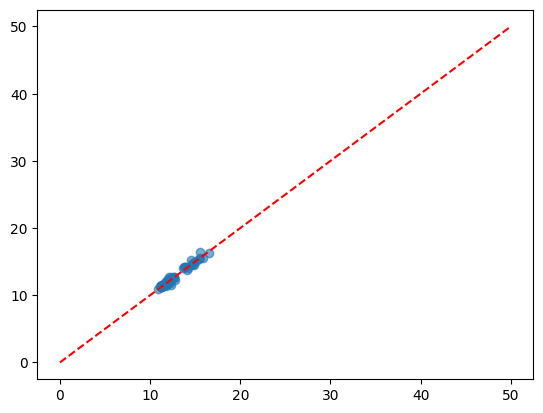

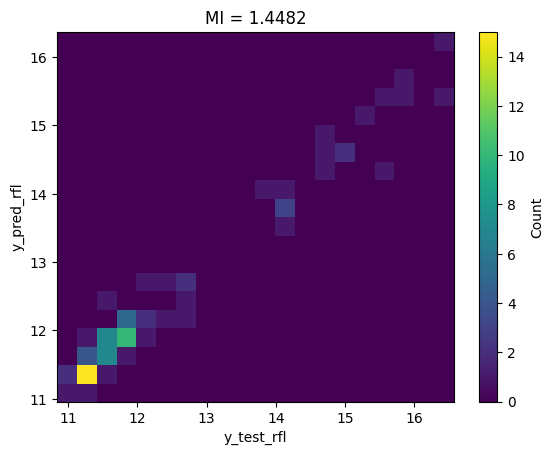

In [116]:
start_time = time.time()

rfl_method2_tune = tune_random_forest(
    x_train_rfl, 
    y_train_rfl,
    cv=5,
    verbose=True
)

rfl_method2_best_model = rfl_method2_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")
# predict on test set
y_pred_rfl = rfl_method2_best_model.predict(x_test_rfl)
plt.scatter(y_test_rfl, y_pred_rfl, alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_test_rfl, y_pred_rfl, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_test_rfl')      # 横轴是真实值
plt.ylabel('y_pred_rfl') # 纵轴是预测值
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

In [117]:
#train test split
X_fso_method2, y_fso_method2 = gene_final_X_y(important_features_fso_sc7, 'FSO_Att', synop_code=7)
x_train_fso,y_train_fso = X_fso_method2.loc[train_idx], y_fso_method2.loc[train_idx]
x_test_fso,y_test_fso = X_fso_method2.loc[test_idx], y_fso_method2.loc[test_idx]

Start tuning...
Dataset size: (335, 11)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE | OOB mutualinfo
--------------------------------------------------------------------------------
         100 |      None |  0.948264 |  0.948264 |  1.209680 |  1.567816
         100 |        10 |  0.948068 |  0.948068 |  1.211970 |  1.585051
         100 |        20 |  0.948298 |  0.948298 |  1.209273 |  1.567816
         150 |      None |  0.948242 |  0.948242 |  1.209938 |  1.605176
         150 |        10 |  0.947950 |  0.947950 |  1.213337 |  1.593246
         150 |        20 |  0.948270 |  0.948270 |  1.209600 |  1.605176

Best result:
Best parameters: n_estimators=100, max_depth=20
Best OOB Score: 0.948298
Best OOB R² Score: 0.948298
Best OOB RMSE: 1.209273
Best OOB mutualinfo: 1.567816
Model training time: 0.93 seconds


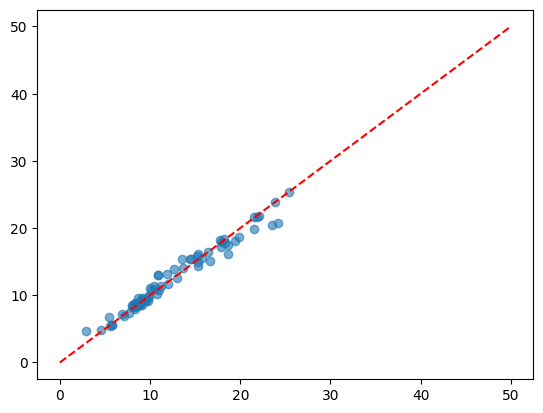

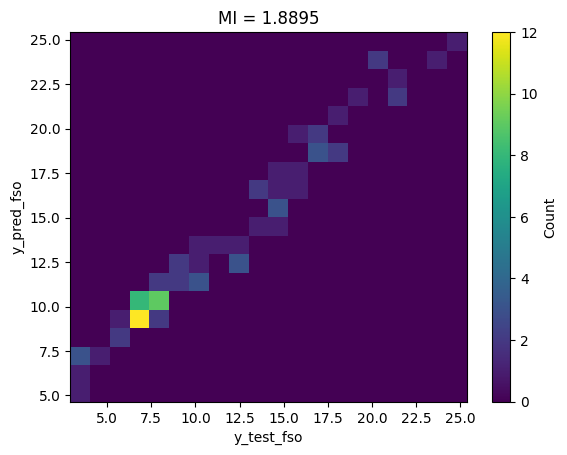

In [118]:
start_time = time.time()

fso_method2_tune = tune_random_forest(
    x_train_fso, 
    y_train_fso,
    cv=5,
    verbose=True
)

fso_method2_best_model = fso_method2_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")
# predict on test set
y_pred_fso = fso_method2_best_model.predict(x_test_fso)
plt.scatter(y_test_fso, y_pred_fso, alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_test_fso, y_pred_fso, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_test_fso')      
plt.ylabel('y_pred_fso') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

In [119]:
#train test split
X_fso_method2_wo, y_fso_method2_wo = gene_final_X_y(important_features_fso_sc7_wo, 'FSO_Att', synop_code=7)
x_train_fso_wo,y_train_fso_wo = X_fso_method2_wo.loc[train_idx], y_fso_method2_wo.loc[train_idx]
x_test_fso_wo,y_test_fso_wo = X_fso_method2_wo.loc[test_idx], y_fso_method2_wo.loc[test_idx]

Start tuning...
Dataset size: (335, 10)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE | OOB mutualinfo
--------------------------------------------------------------------------------
         100 |      None |  0.949110 |  0.949110 |  1.199749 |  1.606535
         100 |        10 |  0.948483 |  0.948483 |  1.207109 |  1.598187
         100 |        20 |  0.949303 |  0.949303 |  1.197470 |  1.611556
         150 |      None |  0.949356 |  0.949356 |  1.196847 |  1.621356
         150 |        10 |  0.949117 |  0.949117 |  1.199658 |  1.616186
         150 |        20 |  0.949478 |  0.949478 |  1.195398 |  1.624573

Best result:
Best parameters: n_estimators=150, max_depth=20
Best OOB Score: 0.949478
Best OOB R² Score: 0.949478
Best OOB RMSE: 1.195398
Best OOB mutualinfo: 1.624573
Model training time: 0.74 seconds


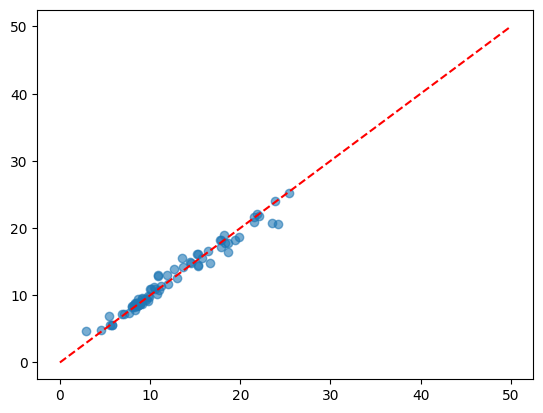

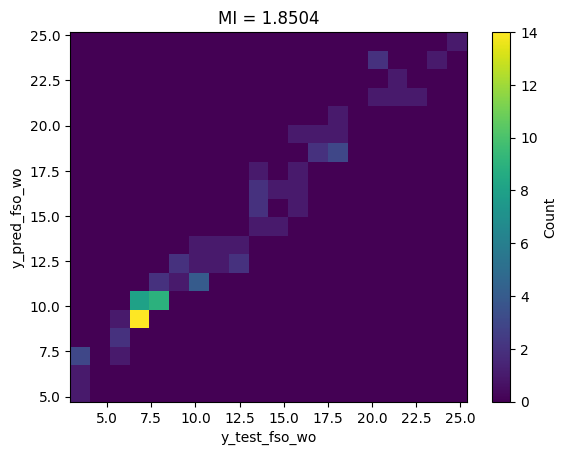

In [120]:
start_time = time.time()

fso_method2_tune_wo = tune_random_forest(
    x_train_fso_wo, 
    y_train_fso_wo,
    cv=5,
    verbose=True
)

fso_method2_best_model_wo = fso_method2_tune_wo['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")
# predict on test set
y_pred_fso_wo = fso_method2_best_model_wo.predict(x_test_fso_wo)
plt.scatter(y_test_fso_wo, y_pred_fso_wo, alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_test_fso_wo, y_pred_fso_wo, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_test_fso_wo')     
plt.ylabel('y_pred_fso_wo') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

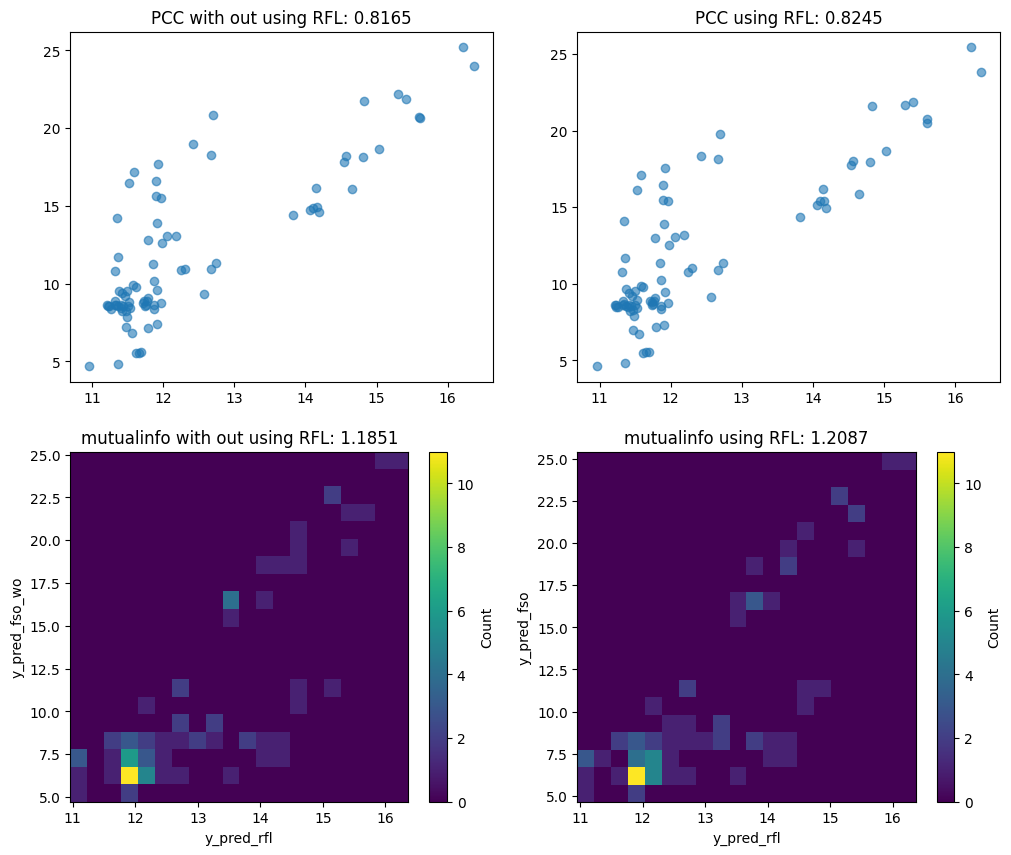

In [121]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.scatter(y_pred_rfl, y_pred_fso_wo, alpha=0.6)
pcc = np.corrcoef(y_pred_rfl, y_pred_fso_wo)[0, 1]
plt.title(f"PCC with out using RFL: {pcc:.4f}")

plt.subplot(2, 2, 2)
plt.scatter(y_pred_rfl, y_pred_fso, alpha=0.6)
pcc = np.corrcoef(y_pred_rfl, y_pred_fso)[0, 1]
plt.title(f"PCC using RFL: {pcc:.4f}")

plt.subplot(2, 2, 3)
mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_rfl, y_pred_fso_wo, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_pred_rfl')      
plt.ylabel('y_pred_fso_wo') 
plt.title(f"mutualinfo with out using RFL: {mutualinfo:.4f}")
plt.colorbar(label='Count')


plt.subplot(2, 2, 4)
mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_rfl, y_pred_fso, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_pred_rfl')      
plt.ylabel('y_pred_fso') 
plt.title(f"mutualinfo using RFL: {mutualinfo:.4f}")
plt.colorbar(label='Count')


In [122]:
important_features_rfl_method2 = ['AbsoluteHumidity',
 'Distance',
 'Frequency',
 'ParticulateMax',
 'RainIntensity',
 'RainIntensityMax',
 'RainIntensityMin',
 'RelativeHumidity',
 'SYNOPCode',
 'Temperature',
 'TemperatureMax',
 'Visibility']

In [123]:

train_idx, test_idx = train_test_split(processed_data.index, test_size=0.2, random_state=42)

In [124]:
#train test split
X_rfl_method2, y_rfl_method2 = gene_final_X_y(important_features_rfl_method2, 'RFL_Att')

x_train_rfl,y_train_rfl = X_rfl_method2.loc[train_idx], y_rfl_method2.loc[train_idx]
x_test_rfl,y_test_rfl = X_rfl_method2.loc[test_idx], y_rfl_method2.loc[test_idx]

In [125]:
start_time = time.time()

rfl_method2_tune = tune_random_forest(
    x_train_rfl, 
    y_train_rfl,
    cv=5,
    verbose=True
)

rfl_method2_best_model = rfl_method2_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")

Start tuning...
Dataset size: (73103, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE | OOB mutualinfo
--------------------------------------------------------------------------------
         100 |      None |  0.971943 |  0.971943 |  0.575890 |  1.016437
         100 |        10 |  0.958502 |  0.958502 |  0.700376 |  0.935811
         100 |        20 |  0.971814 |  0.971814 |  0.577213 |  1.011964
         150 |      None |  0.972440 |  0.972440 |  0.570767 |  1.021051
         150 |        10 |  0.958772 |  0.958772 |  0.698095 |  0.939736
         150 |        20 |  0.972279 |  0.972279 |  0.572430 |  1.012008

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.972440
Best OOB R² Score: 0.972440
Best OOB RMSE: 0.570767
Best OOB mutualinfo: 1.021051
Model training time: 74.18 seconds

In [126]:
# predict on test set
y_pred_rfl = rfl_method2_best_model.predict(x_test_rfl)

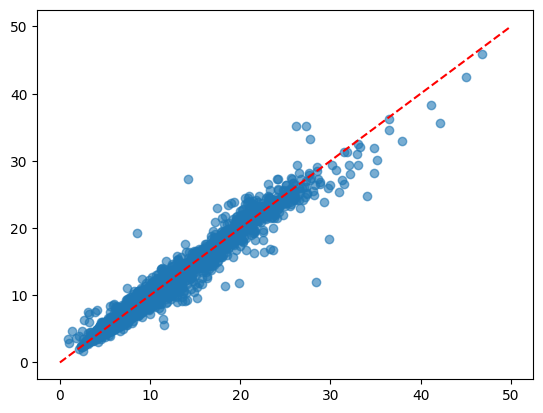

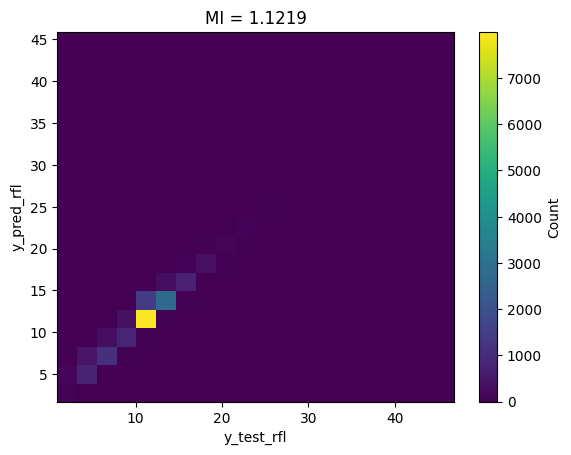

In [127]:
plt.scatter(y_test_rfl, y_pred_rfl, alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_test_rfl, y_pred_rfl, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_test_rfl')      # 横轴是真实值
plt.ylabel('y_pred_rfl') # 纵轴是预测值
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

In [128]:
important_features_fso_method2_without_rfl = ['AbsoluteHumidity',
 'Distance',
 'Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'TemperatureMin',
 'Time',
 'Visibility',
 'VisibilityMin']

In [129]:
#train test split
X_fso_method2, y_fso_method2 = gene_final_X_y(important_features_fso_method2_without_rfl, 'FSO_Att')

x_train_fso_wo,y_train_fso_wo = X_fso_method2.loc[train_idx], y_fso_method2.loc[train_idx]
x_test_fso_wo,y_test_fso_wo = X_fso_method2.loc[test_idx], y_fso_method2.loc[test_idx]

In [130]:
start_time = time.time()

fso_method2_tune_without_rfl = tune_random_forest(
    x_train_fso_wo, 
    y_train_fso_wo,
    cv=5,
    verbose=True
)

fso_method2_best_model_without_rfl = fso_method2_tune_without_rfl['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")

Start tuning...
Dataset size: (73103, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE | OOB mutualinfo
--------------------------------------------------------------------------------
         100 |      None |  0.957522 |  0.957522 |  0.806126 |  1.342302
         100 |        10 |  0.904458 |  0.904458 |  1.208980 |  1.019421
         100 |        20 |  0.956054 |  0.956054 |  0.819938 |  1.332135
         150 |      None |  0.958150 |  0.958150 |  0.800147 |  1.349192
         150 |        10 |  0.904543 |  0.904543 |  1.208441 |  1.020566
         150 |        20 |  0.956636 |  0.956636 |  0.814497 |  1.334763

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.958150
Best OOB R² Score: 0.958150
Best OOB RMSE: 0.800147
Best OOB mutualinfo: 1.349192
Model training time: 89.54 seconds

In [131]:
y_pred_fso_without_rfl = fso_method2_best_model_without_rfl.predict(x_test_fso_wo)

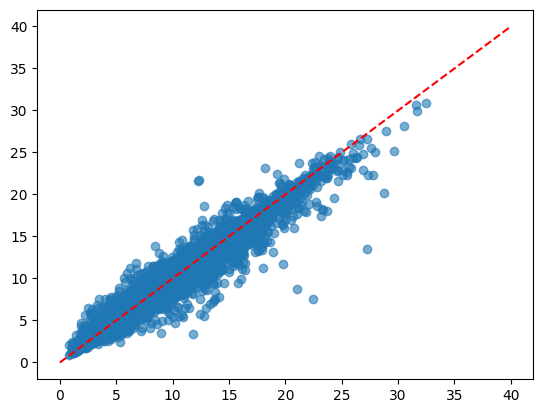

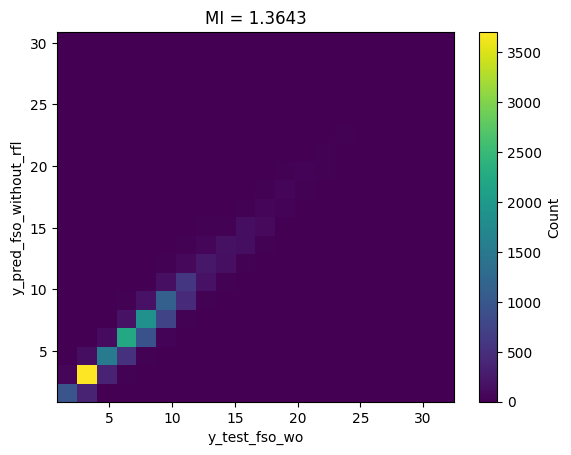

In [132]:
plt.scatter(y_test_fso_wo, y_pred_fso_without_rfl, alpha=0.6)
plt.plot([0, 40], [0, 40], color='red', linestyle='--')
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_test_fso_wo, y_pred_fso_without_rfl, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_test_fso_wo')      # 横轴是真实值
plt.ylabel('y_pred_fso_without_rfl') # 纵轴是预测值
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

In [133]:
important_features_fso_method2 = ['AbsoluteHumidity',
 'Distance',
 'Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'TemperatureMin',
 'Time',
 'Visibility',
 'VisibilityMin',
 'RFL_Att']

In [134]:
#train test split
X_fso_method2, y_fso_method2 = gene_final_X_y(important_features_fso_method2, 'FSO_Att')

x_train_fso,y_train_fso = X_fso_method2.loc[train_idx], y_fso_method2.loc[train_idx]
x_test_fso,y_test_fso = X_fso_method2.loc[test_idx], y_fso_method2.loc[test_idx]

In [135]:
start_time = time.time()

fso_method2_tune = tune_random_forest(
    x_train_fso, 
    y_train_fso,
    cv=5,
    verbose=True
)

fso_method2_best_model = fso_method2_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")

Start tuning...
Dataset size: (73103, 13)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE | OOB mutualinfo
--------------------------------------------------------------------------------
         100 |      None |  0.954168 |  0.954168 |  0.837352 |  1.322469
         100 |        10 |  0.899119 |  0.899119 |  1.242303 |  0.988601
         100 |        20 |  0.952480 |  0.952480 |  0.852628 |  1.310771
         150 |      None |  0.954721 |  0.954721 |  0.832279 |  1.330412
         150 |        10 |  0.898942 |  0.898942 |  1.243394 |  0.988539
         150 |        20 |  0.952995 |  0.952995 |  0.847997 |  1.315610

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.954721
Best OOB R² Score: 0.954721
Best OOB RMSE: 0.832279
Best OOB mutualinfo: 1.330412
Model training time: 100.45 second

In [136]:
y_pred_fso = fso_method2_best_model.predict(x_test_fso)

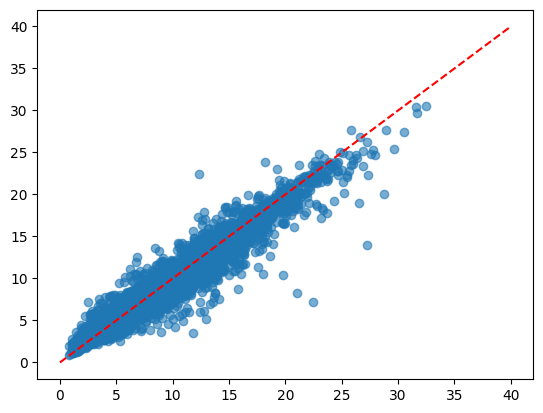

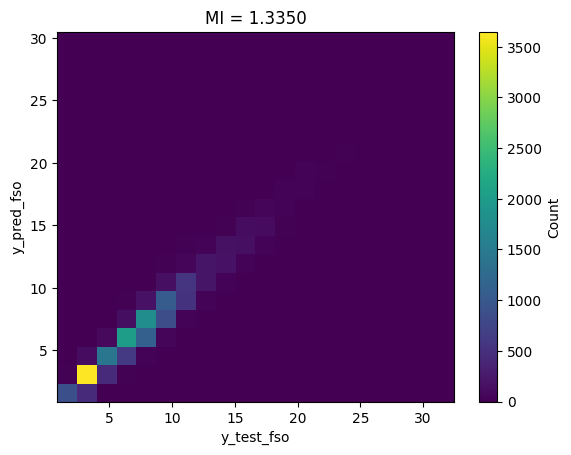

In [137]:
plt.scatter(y_test_fso, y_pred_fso, alpha=0.6)
plt.plot([0, 40], [0, 40], color='red', linestyle='--')
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_test_fso, y_pred_fso, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_test_fso')      
plt.ylabel('y_pred_fso') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

Pearson correlation coefficient: 0.087808


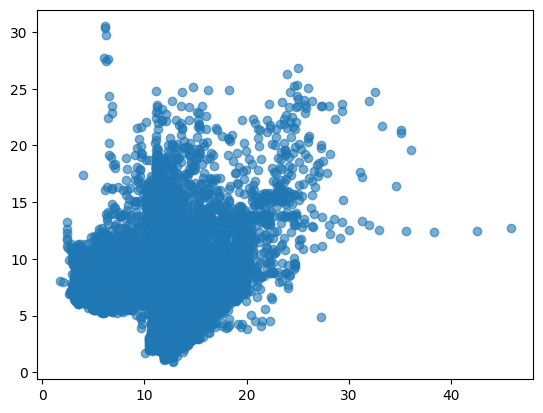

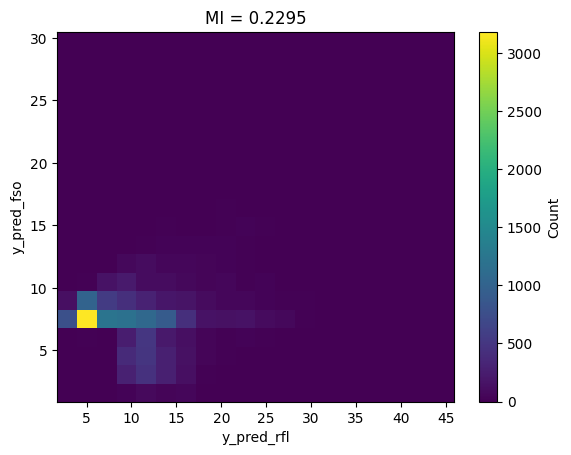

In [138]:
plt.scatter(y_pred_rfl, y_pred_fso, alpha=0.6)
#pcc
pcc = np.corrcoef(y_pred_rfl, y_pred_fso)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_rfl, y_pred_fso, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_pred_rfl')     
plt.ylabel('y_pred_fso') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

Pearson correlation coefficient: 0.083812


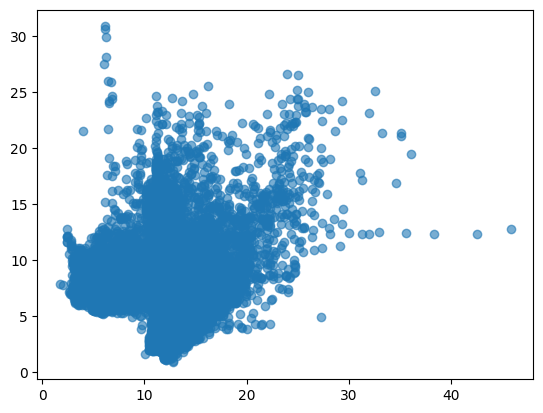

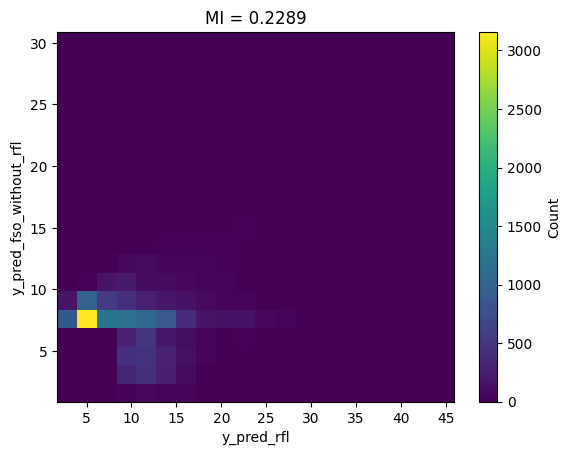

In [139]:
plt.scatter(y_pred_rfl, y_pred_fso_without_rfl, alpha=0.6)
#pcc
pcc = np.corrcoef(y_pred_rfl, y_pred_fso_without_rfl)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_rfl, y_pred_fso_without_rfl, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_pred_rfl')      
plt.ylabel('y_pred_fso_without_rfl') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

Pearson correlation coefficient: 0.088429


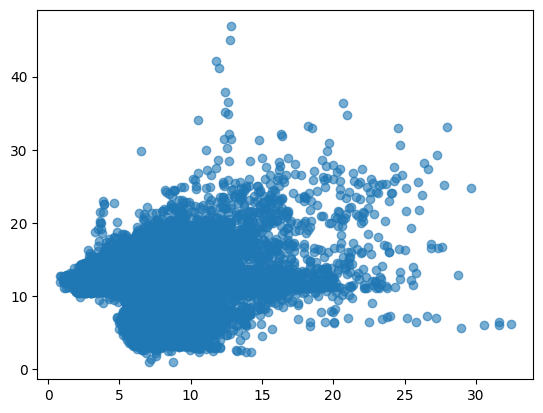

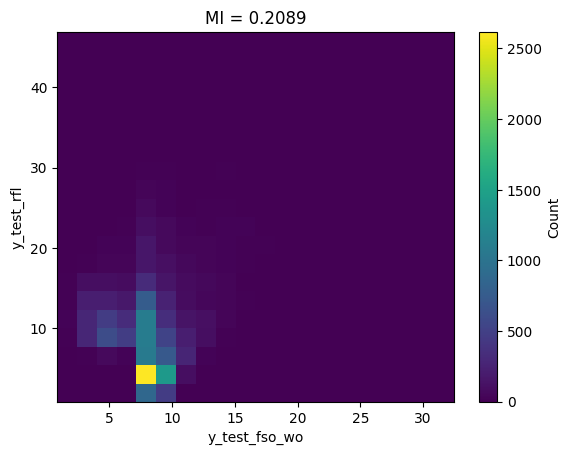

In [140]:

plt.scatter(y_test_fso_wo, y_test_rfl, alpha=0.6)
#pcc
pcc = np.corrcoef(y_test_fso_wo, y_test_rfl)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_test_fso_wo, y_test_rfl, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_test_fso_wo')      
plt.ylabel('y_test_rfl') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

In [141]:
#train test split
_, y_rfl_7 = gene_final_X_y(important_features_rfl_method2, 'RFL_Att', synop_code=7)
_, y_fso_7 = gene_final_X_y(important_features_rfl_method2, 'FSO_Att', synop_code=7)

Pearson correlation coefficient: 0.804480


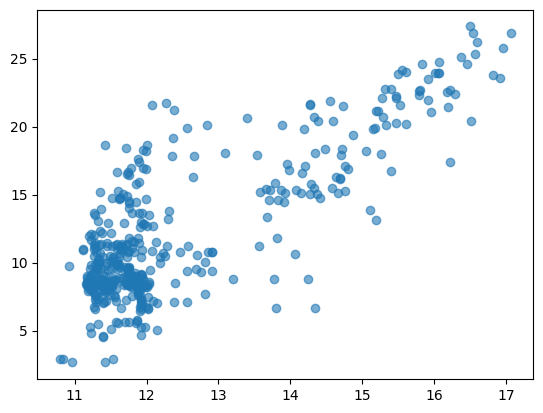

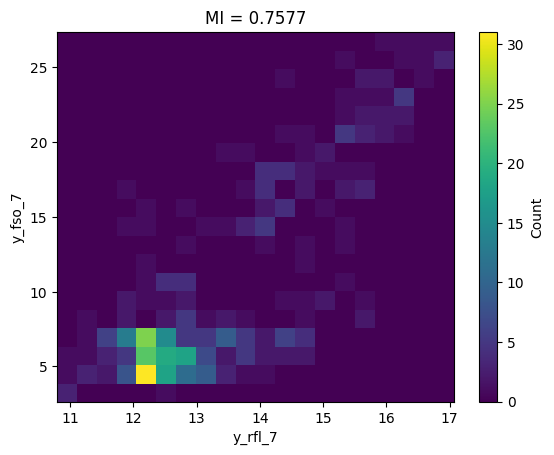

In [142]:
plt.scatter(y_rfl_7, y_fso_7, alpha=0.6)
#pcc
pcc = np.corrcoef(y_rfl_7, y_fso_7)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_rfl_7, y_fso_7, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_rfl_7')      
plt.ylabel('y_fso_7') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

In [143]:
_,synop_code = gene_final_X_y(important_features_rfl_method2, 'SYNOPCode')



In [144]:
synop_code_test = synop_code.loc[test_idx]

In [145]:
y_test_fso_wo

23811     3.555870
33249     4.029149
31945     5.697896
3431     11.731163
66292     4.094981
           ...    
89409     7.105075
25495     2.729125
76781     6.399596
83544     3.094887
59214     4.991111
Name: FSO_Att, Length: 18276, dtype: float64

In [146]:
y_test_fso

23811     3.555870
33249     4.029149
31945     5.697896
3431     11.731163
66292     4.094981
           ...    
89409     7.105075
25495     2.729125
76781     6.399596
83544     3.094887
59214     4.991111
Name: FSO_Att, Length: 18276, dtype: float64

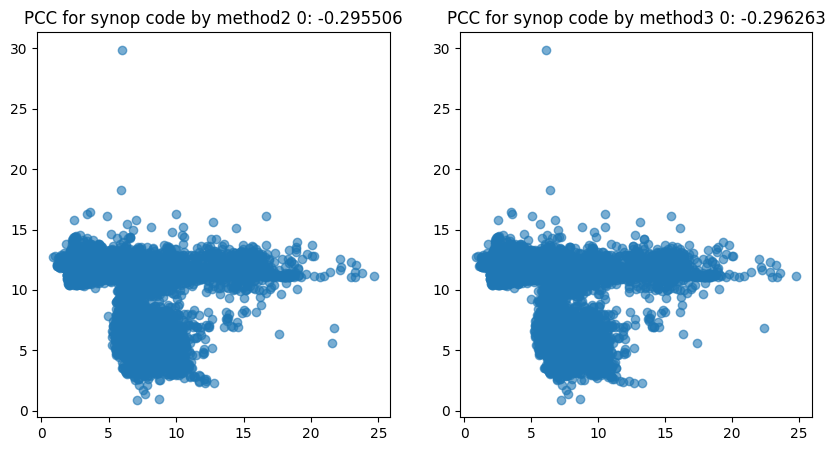

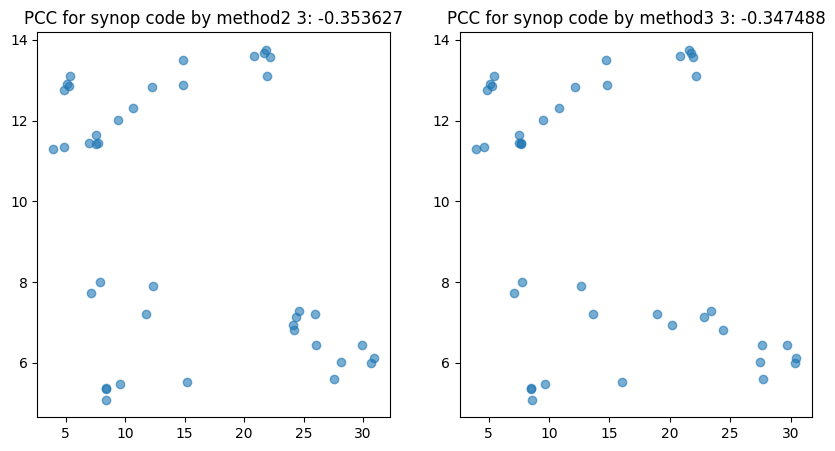

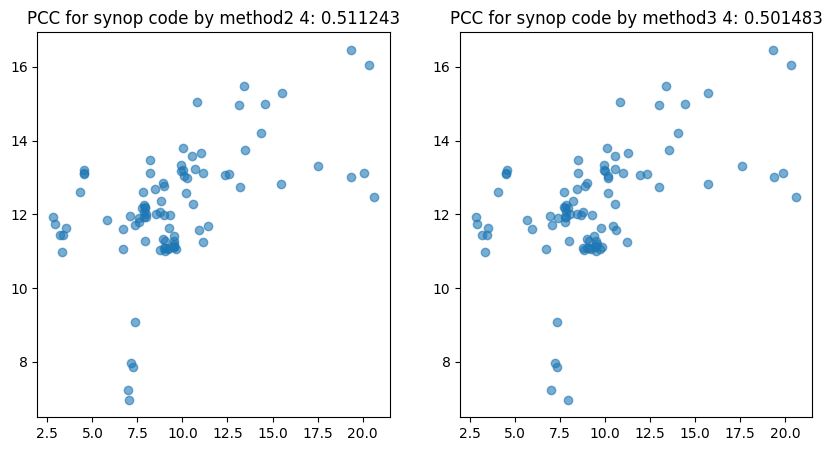

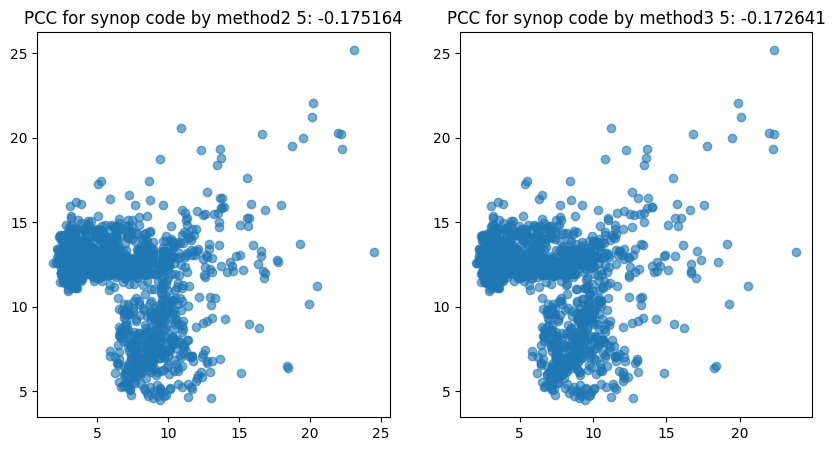

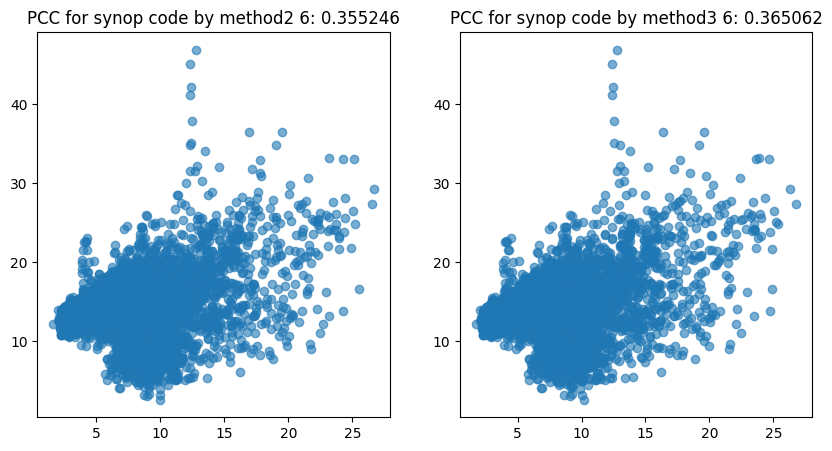

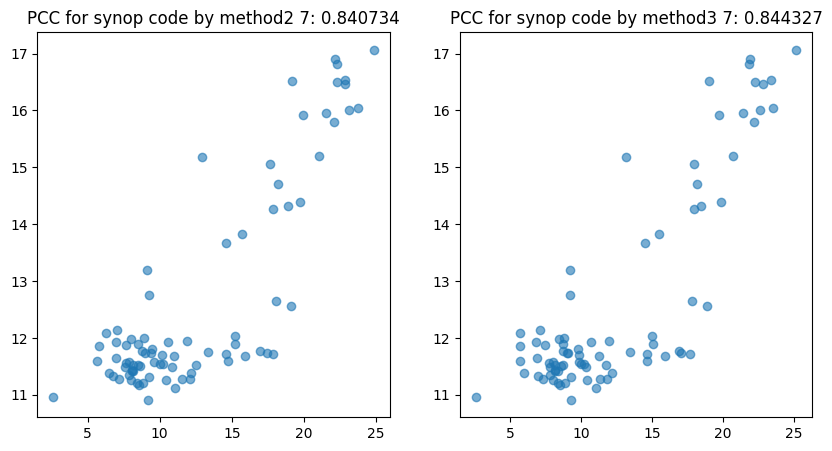

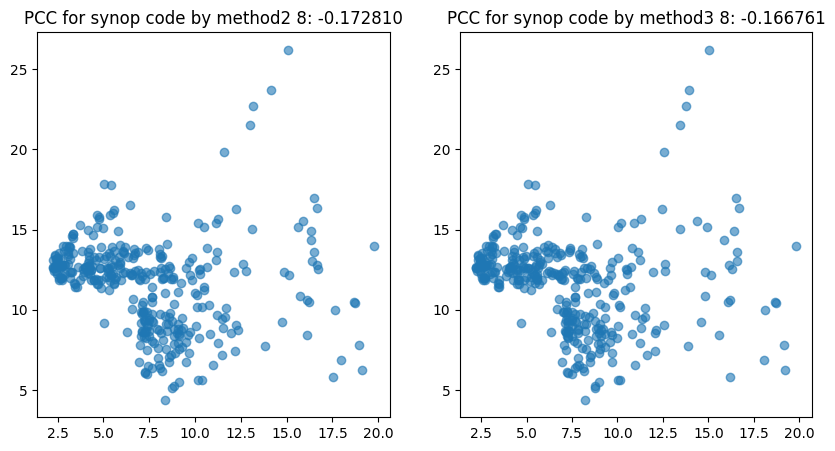

In [147]:
data = []
for sy in [0,3,4,5,6,7,8]:
    data_sy = []
    data_sy.append(sy)
    idx = synop_code_test==sy
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(y_pred_fso_without_rfl[idx], y_test_rfl[idx], alpha=0.6)
    mse = mean_squared_error(y_pred_fso_without_rfl[idx], y_test_rfl[idx])
    rmse = np.sqrt(mse)
    #pcc
    pcc = np.corrcoef(y_pred_fso_without_rfl[idx], y_test_rfl[idx])[0, 1]
    plt.title(f"PCC for synop code by method2 {sy}: {pcc:.6f}")
    data_sy.append(float(pcc))
    data_sy.append(float(mse))
    data_sy.append(float(rmse))
    plt.subplot(122)
    plt.scatter(y_pred_fso[idx], y_test_rfl[idx], alpha=0.6)
    #pcc
    mse = mean_squared_error(y_pred_fso[idx], y_test_rfl[idx])
    rmse = np.sqrt(mse)
    pcc = np.corrcoef(y_pred_fso[idx], y_test_rfl[idx])[0, 1]
    data_sy.append(float(pcc))
    data_sy.append(float(mse))
    data_sy.append(float(rmse))
    plt.title(f"PCC for synop code by method3 {sy}: {pcc:.6f}")
    plt.show()
    data.append(data_sy)

In [148]:
pd.DataFrame(data,columns=["synop","pcc_method2","pcc_method3","mse_method2","rmse_method2","mse_method3","rmse_method3"])

synop  pcc_method2  pcc_method3  mse_method2  rmse_method2  mse_method3  \
0      0    -0.295506    42.120794     6.490053     -0.296263    42.045991   
1      3    -0.353627   140.058725    11.834641     -0.347488   130.735838   
2      4     0.511243    17.690955     4.206062      0.501483    17.833713   
3      5    -0.175164    42.249733     6.499979     -0.172641    42.203409   
4      6     0.355246    62.154850     7.883835      0.365062    61.694030   
5      7     0.840734    16.874413     4.107848      0.844327    16.448030   
6      8    -0.172810    43.531498     6.597840     -0.166761    43.360425   

   rmse_method3  
0      6.484288  
1     11.433977  
2      4.222998  
3      6.496415  
4      7.854555  
5      4.055617  
6      6.584863

In [12]:
pccsaved = {"background":[-0.2677,-0.4243,0.5779,-0.1556,0.3483,0.8045,-0.1689],
            "general":[-0.295506,-0.353627,0.511243,-0.175164,0.355246,0.840734,-0.172810],
            "cascade": [-0.296263,-0.347488,0.501483,-0.172641,0.365062,0.844327,-0.166761]}

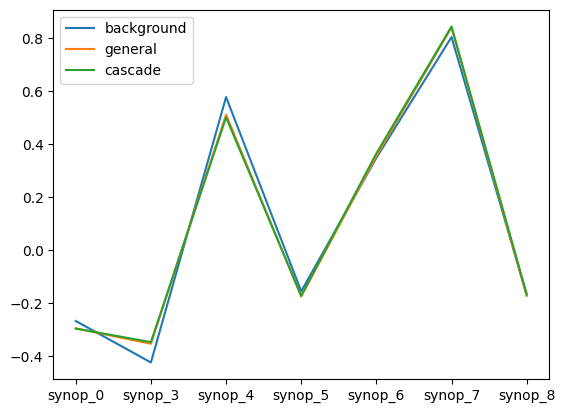

In [13]:
plt.plot(["synop_0","synop_3","synop_4","synop_5","synop_6","synop_7","synop_8"],
        pccsaved["background"],label="background")
plt.plot(["synop_0","synop_3","synop_4","synop_5","synop_6","synop_7","synop_8"],
        pccsaved["general"],label="general")
plt.plot(["synop_0","synop_3","synop_4","synop_5","synop_6","synop_7","synop_8"],
        pccsaved["cascade"],label="cascade")
plt.legend()

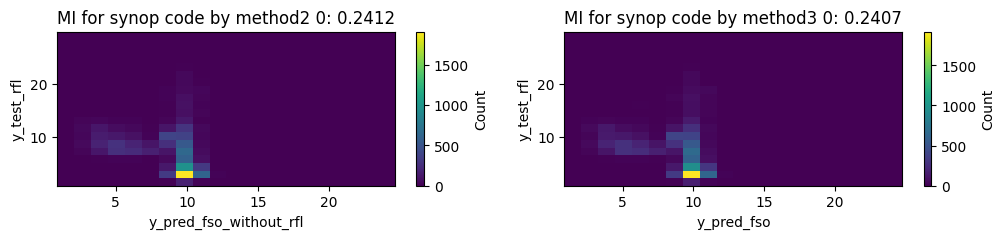

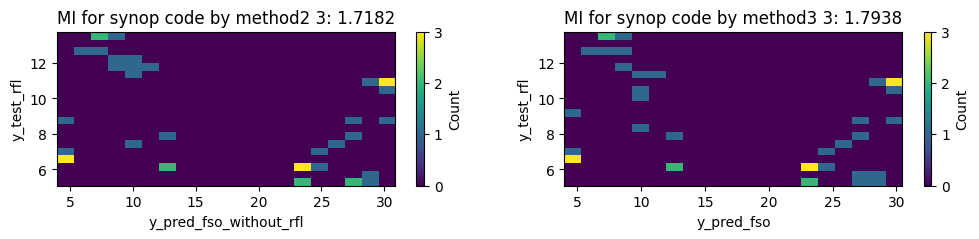

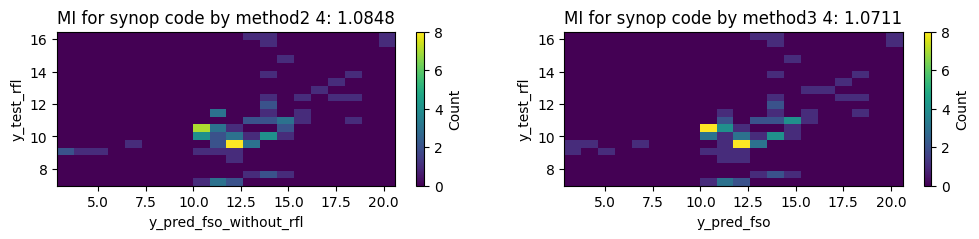

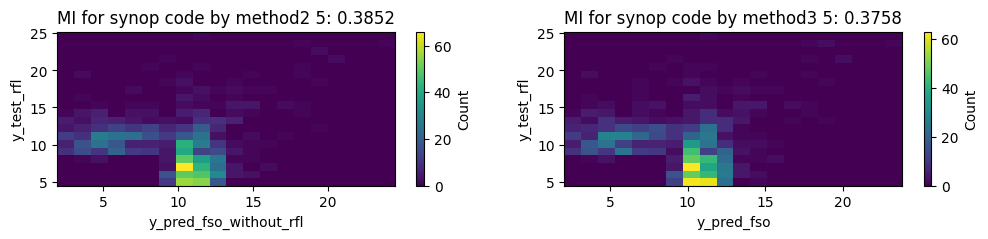

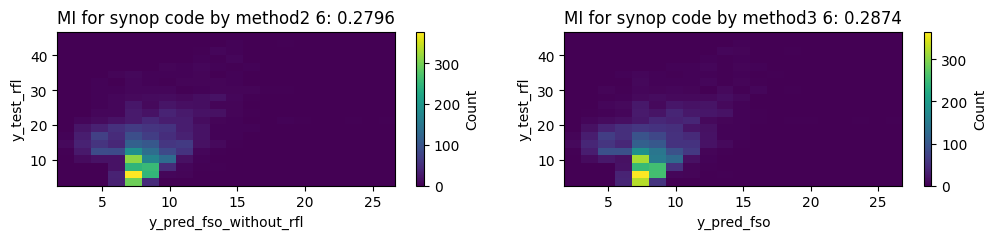

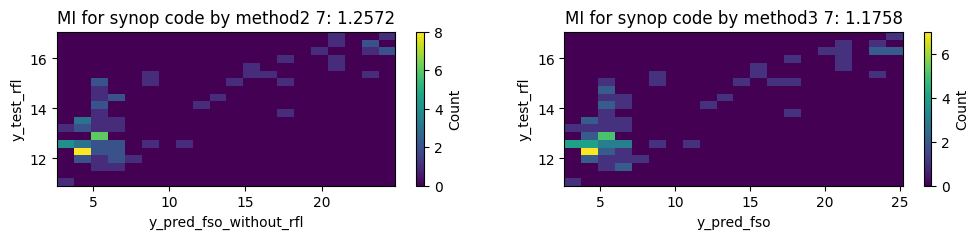

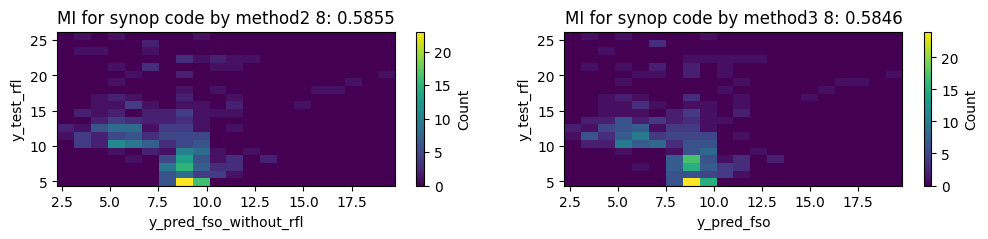

<Figure size 640x480 with 0 Axes>

In [149]:
data = []
for sy in [0,3,4,5,6,7,8]:
    data_sy = []
    data_sy.append(sy)
    idx = synop_code_test==sy
    plt.figure(figsize=(12,2))
    plt.subplot(121)
    mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_fso_without_rfl[idx], y_test_rfl[idx], bins=20)
    plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
               extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
    plt.xlabel(f'y_pred_fso_without_rfl')      
    plt.ylabel(f'y_test_rfl')
    plt.title(f"MI for synop code by method2 {sy}: {mutualinfo:.4f}")
    plt.colorbar(label='Count')
    data_sy.append(float(mutualinfo))
    
    plt.subplot(122)
    mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_fso[idx], y_test_rfl[idx], bins=20)
    plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
               extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
    plt.xlabel(f'y_pred_fso')      
    plt.ylabel(f'y_test_rfl')
    plt.title(f"MI for synop code by method3 {sy}: {mutualinfo:.4f}")
    plt.colorbar(label='Count')
    data_sy.append(float(mutualinfo))
    plt.show()
    
    data.append(data_sy)
plt.savefig("synop*rfl")

In [150]:
pd.DataFrame(data,columns=["synop","MI_method2","MI_method3"])

synop  MI_method2  MI_method3
0      0    0.241153    0.240733
1      3    1.718214    1.793845
2      4    1.084842    1.071063
3      5    0.385170    0.375839
4      6    0.279624    0.287375
5      7    1.257215    1.175816
6      8    0.585535    0.584647

In [61]:
from sklearn.metrics import mean_squared_error

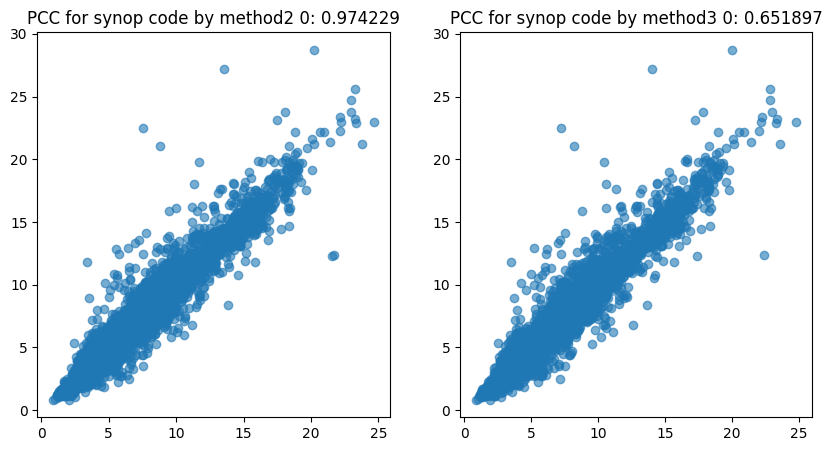

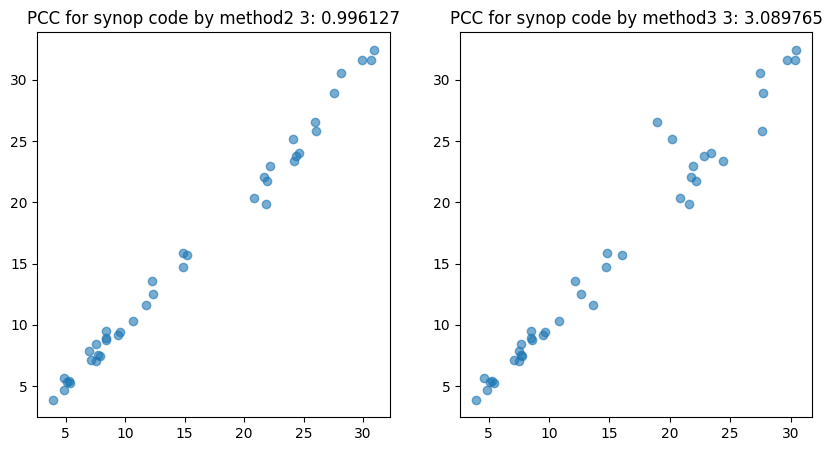

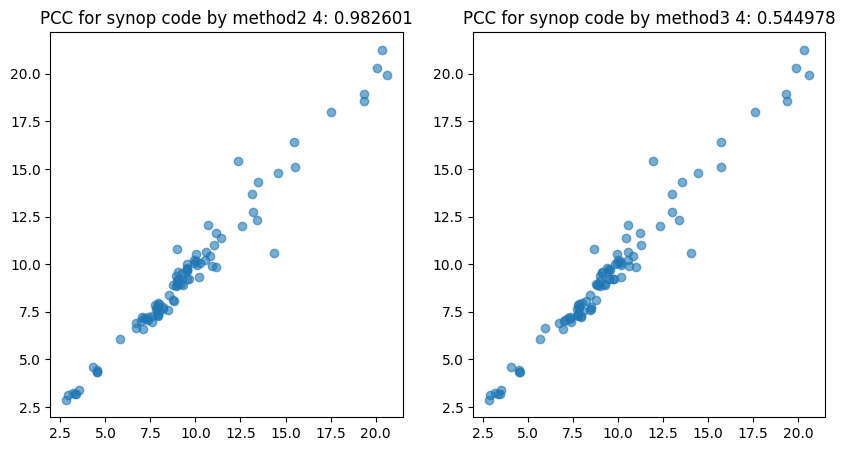

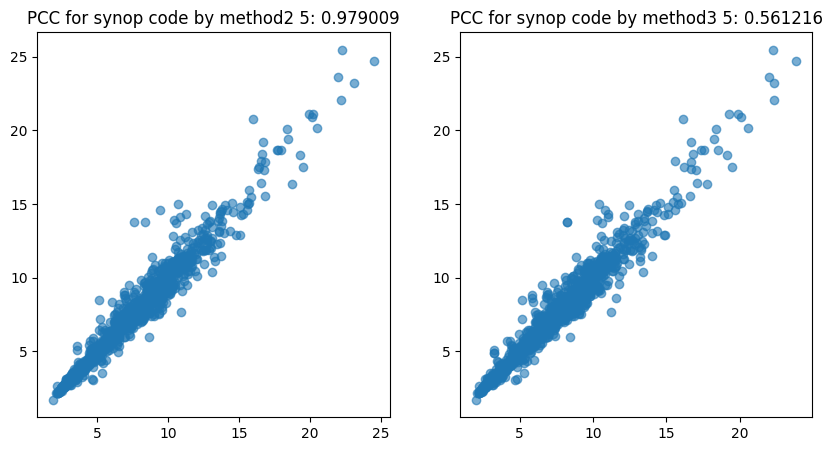

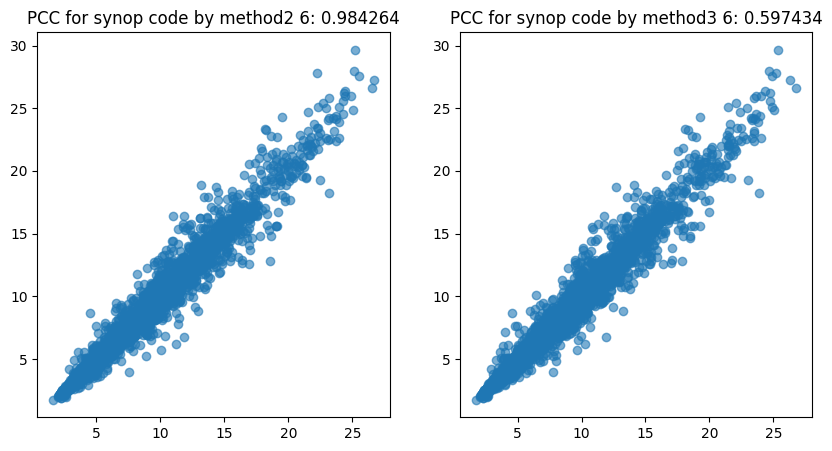

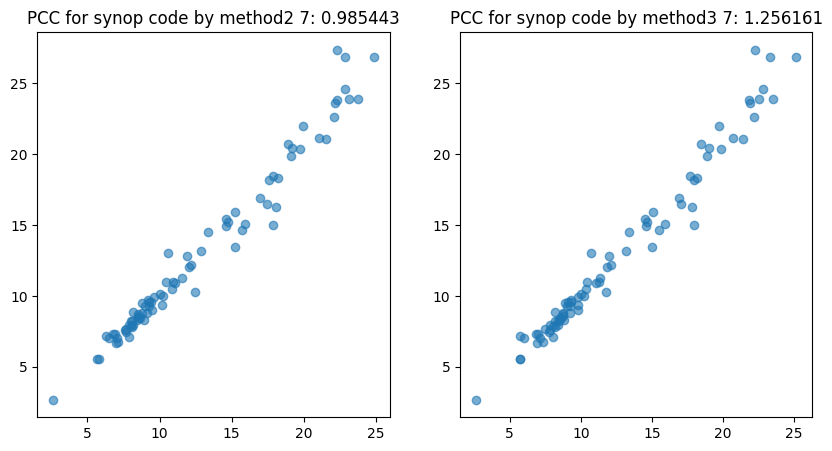

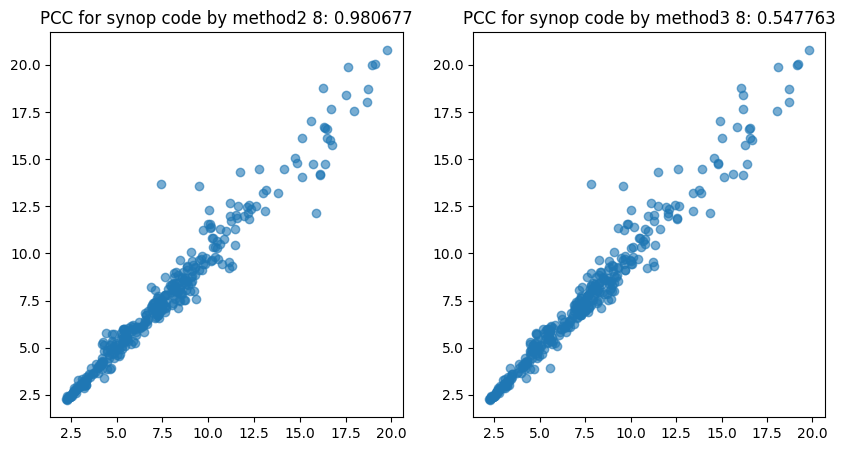

In [152]:
data = []
for sy in [0,3,4,5,6,7,8]:
    data_sy = []
    data_sy.append(sy)
    idx = synop_code_test==sy
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(y_pred_fso_without_rfl[idx], y_test_fso[idx], alpha=0.6)
    #pcc
    pcc = np.corrcoef(y_pred_fso_without_rfl[idx], y_test_fso[idx])[0, 1]
    mse = mean_squared_error(y_pred_fso_without_rfl[idx], y_test_fso[idx])
    rmse = np.sqrt(mse)
    plt.title(f"PCC for synop code by method2 {sy}: {pcc:.6f}")
    data_sy.append(float(pcc))
    data_sy.append(float(mse))
    data_sy.append(float(rmse))
    plt.subplot(122)
    plt.scatter(y_pred_fso[idx], y_test_fso[idx], alpha=0.6)
    #pcc
    pcc = np.corrcoef(y_pred_fso[idx], y_test_fso[idx])[0, 1]
    mse = mean_squared_error(y_pred_fso[idx], y_test_fso[idx])
    rmse = np.sqrt(mse)
    data_sy.append(float(pcc))
    data_sy.append(float(mse))
    data_sy.append(float(rmse))
    plt.title(f"PCC for synop code by method3 {sy}: {mse:.6f}")
    plt.show()
    data.append(data_sy)

In [153]:
fso_0 = pd.DataFrame(data,columns=["synop","pcc_method2","mse_method2","rmse_method2","pcc_method3","mse_method3","rmse_method3"])
fso_0

synop  pcc_method2  mse_method2  rmse_method2  pcc_method3  mse_method3  \
0      0     0.974229     0.610673      0.781456     0.972476     0.651897   
1      3     0.996127     0.745598      0.863480     0.983376     3.089765   
2      4     0.982601     0.509831      0.714025     0.981296     0.544978   
3      5     0.979009     0.520133      0.721203     0.977406     0.561216   
4      6     0.984264     0.569498      0.754651     0.983493     0.597434   
5      7     0.985443     1.258490      1.121824     0.986329     1.256161   
6      8     0.980677     0.559565      0.748041     0.981195     0.547763   

   rmse_method3  
0      0.807402  
1      1.757773  
2      0.738226  
3      0.749144  
4      0.772938  
5      1.120786  
6      0.740110

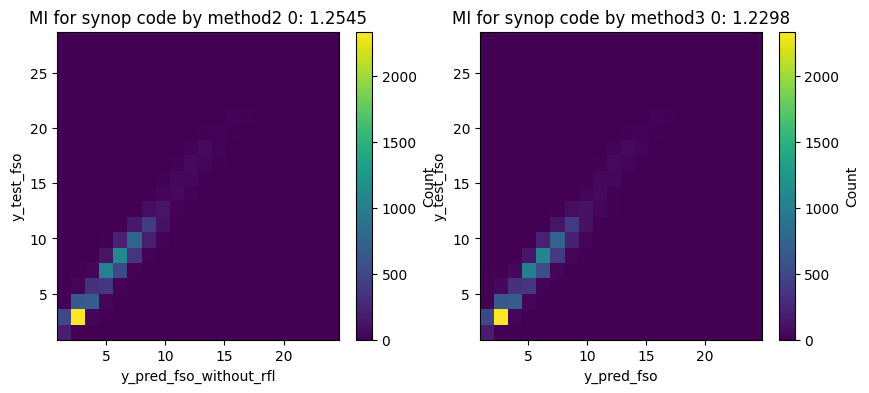

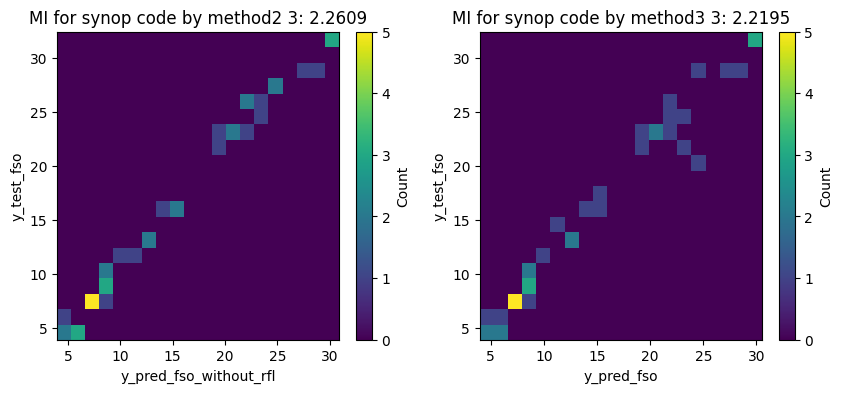

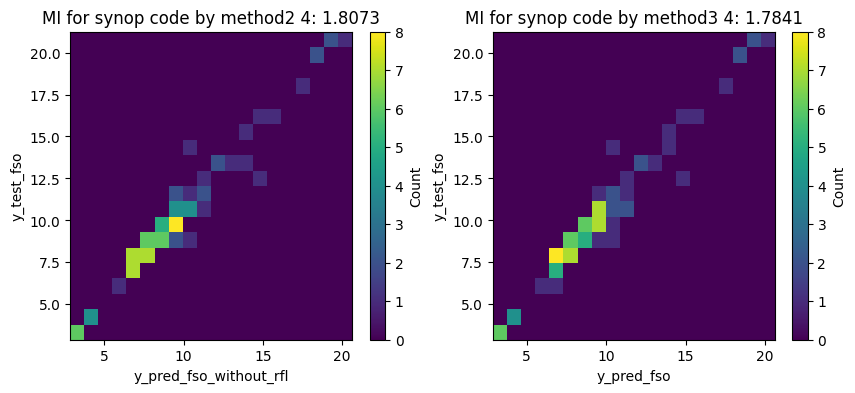

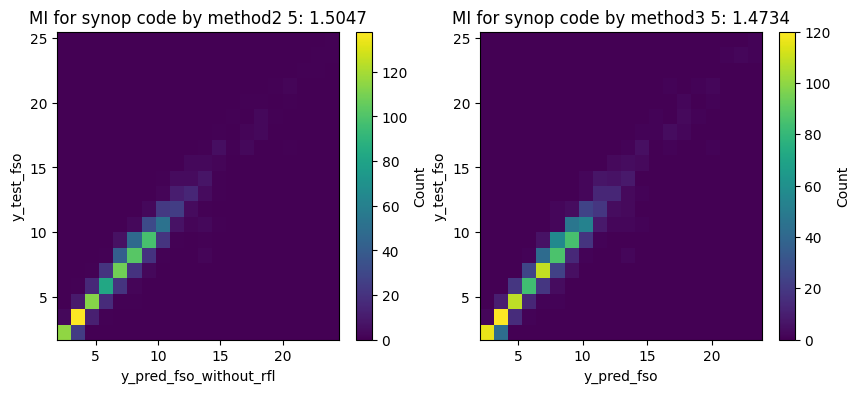

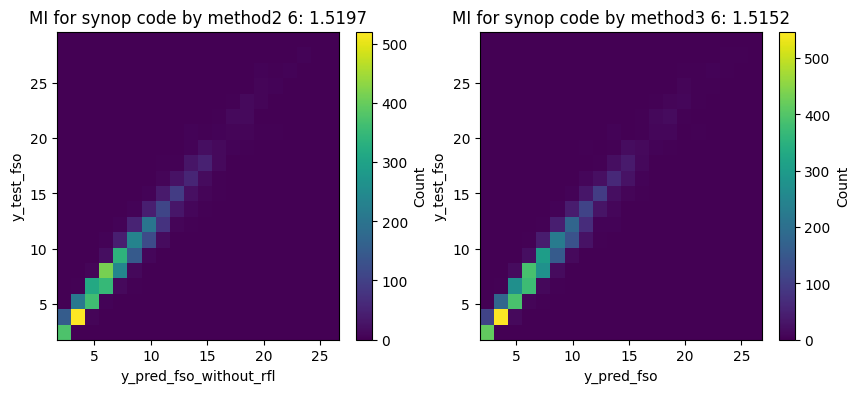

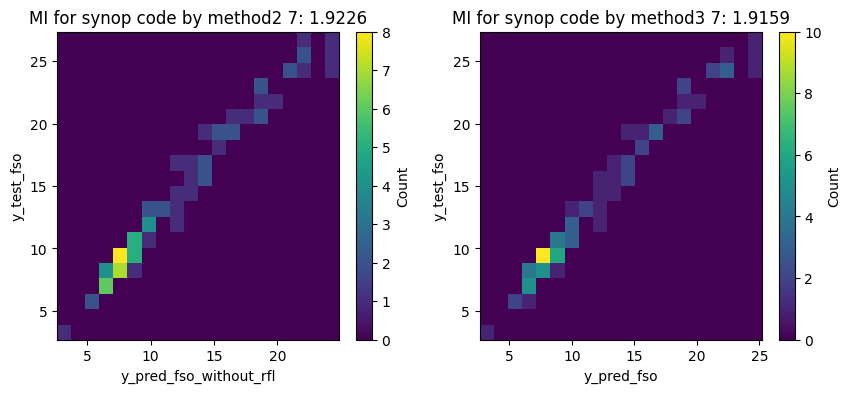

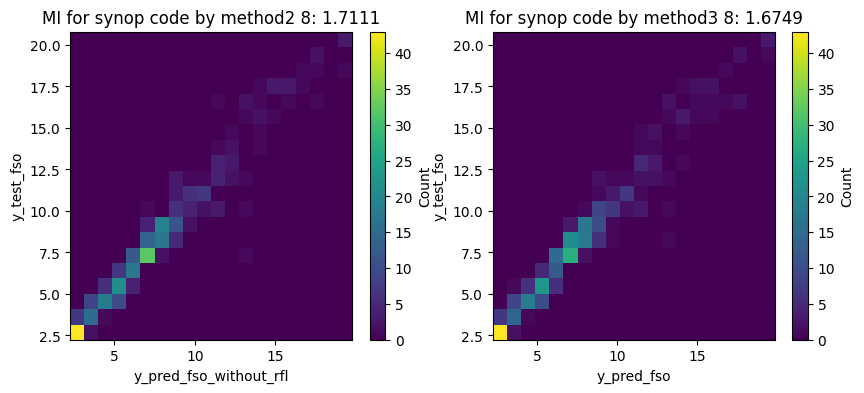

In [203]:
data = []
for sy in [0,3,4,5,6,7,8]:
    data_sy = []
    data_sy.append(sy)
    idx = synop_code_test==sy
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_fso_without_rfl[idx], y_test_fso[idx], bins=20)
    plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
               extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
    plt.xlabel(f'y_pred_fso_without_rfl')      
    plt.ylabel(f'y_test_fso')
    plt.title(f"MI for synop code by method2 {sy}: {mutualinfo:.4f}")
    plt.colorbar(label='Count')
    data_sy.append(float(mutualinfo))
    
    plt.subplot(122)
    mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_fso[idx], y_test_fso[idx], bins=20)
    plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
               extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
    plt.xlabel(f'y_pred_fso')      
    plt.ylabel(f'y_test_fso')
    plt.title(f"MI for synop code by method3 {sy}: {mutualinfo:.4f}")
    plt.colorbar(label='Count')
    data_sy.append(float(mutualinfo))
    plt.show()
    data.append(data_sy)

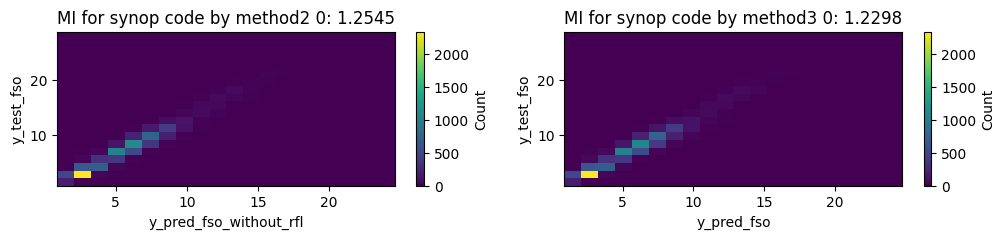

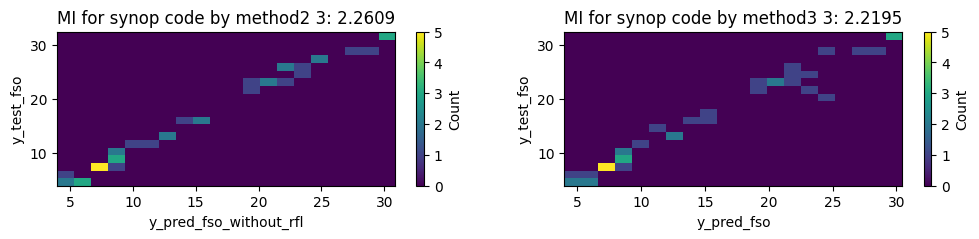

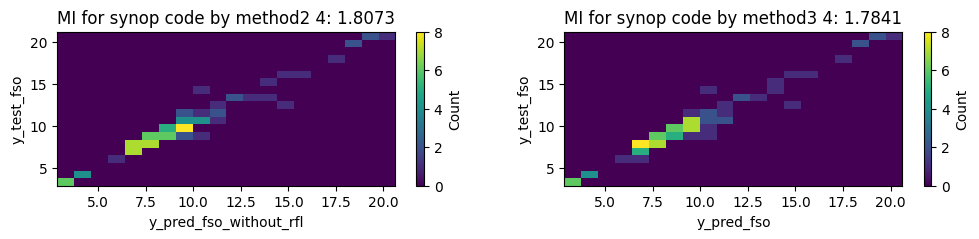

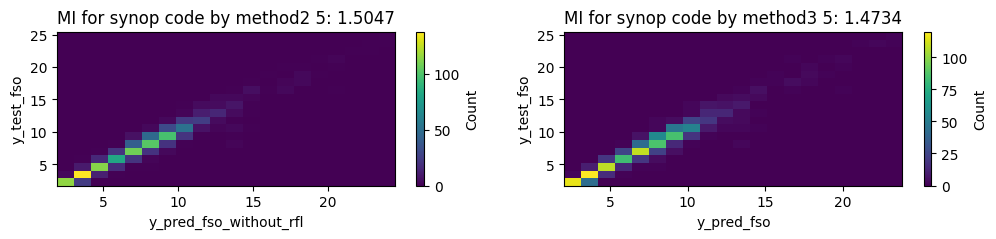

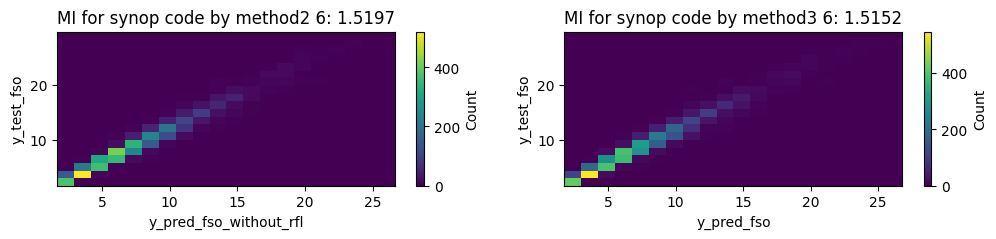

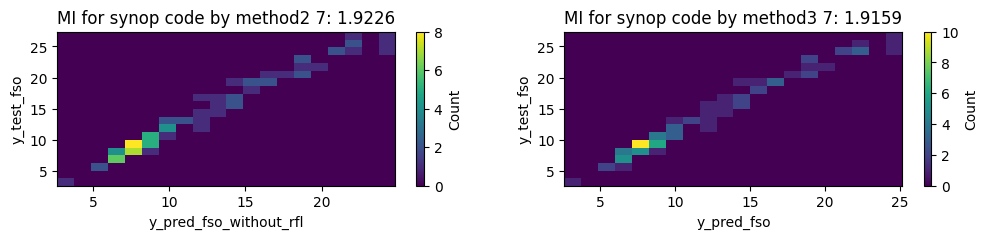

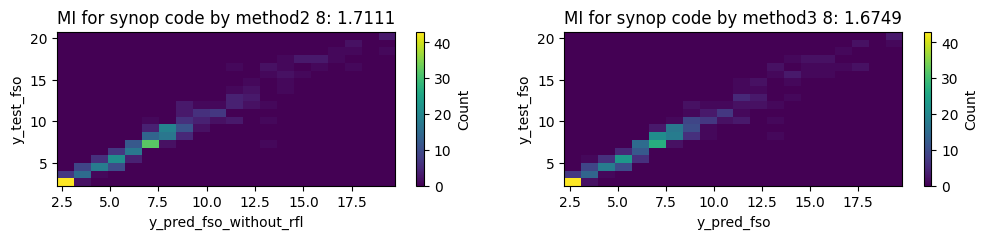

In [154]:
data = []
for sy in [0,3,4,5,6,7,8]:
    data_sy = []
    data_sy.append(sy)
    idx = synop_code_test==sy
    plt.figure(figsize=(12,2))
    plt.subplot(121)
    mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_fso_without_rfl[idx], y_test_fso[idx], bins=20)
    plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
               extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
    plt.xlabel(f'y_pred_fso_without_rfl')      
    plt.ylabel(f'y_test_fso')
    plt.title(f"MI for synop code by method2 {sy}: {mutualinfo:.4f}")
    plt.colorbar(label='Count')
    data_sy.append(float(mutualinfo))
    
    plt.subplot(122)
    mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_fso[idx], y_test_fso[idx], bins=20)
    plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
               extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
    plt.xlabel(f'y_pred_fso')      
    plt.ylabel(f'y_test_fso')
    plt.title(f"MI for synop code by method3 {sy}: {mutualinfo:.4f}")
    plt.colorbar(label='Count')
    data_sy.append(float(mutualinfo))
    plt.show()
    data.append(data_sy)

In [155]:
fso_MI = pd.DataFrame(data,columns=["synop","MI_method2","MI_method3"])
fso_MI

synop  MI_method2  MI_method3
0      0    1.254522    1.229785
1      3    2.260933    2.219512
2      4    1.807338    1.784093
3      5    1.504709    1.473426
4      6    1.519745    1.515235
5      7    1.922635    1.915926
6      8    1.711149    1.674869

In [156]:
fso = pd.concat([fso_0,fso_MI],axis=1)
fso

synop  pcc_method2  mse_method2  rmse_method2  pcc_method3  mse_method3  \
0      0     0.974229     0.610673      0.781456     0.972476     0.651897   
1      3     0.996127     0.745598      0.863480     0.983376     3.089765   
2      4     0.982601     0.509831      0.714025     0.981296     0.544978   
3      5     0.979009     0.520133      0.721203     0.977406     0.561216   
4      6     0.984264     0.569498      0.754651     0.983493     0.597434   
5      7     0.985443     1.258490      1.121824     0.986329     1.256161   
6      8     0.980677     0.559565      0.748041     0.981195     0.547763   

   rmse_method3  synop  MI_method2  MI_method3  
0      0.807402      0    1.254522    1.229785  
1      1.757773      3    2.260933    2.219512  
2      0.738226      4    1.807338    1.784093  
3      0.749144      5    1.504709    1.473426  
4      0.772938      6    1.519745    1.515235  
5      1.120786      7    1.922635    1.915926  
6      0.740110      8    1.711149    1.674869

In [72]:
def load_and_plot_method2_result(target_type, divide_feature,synop_code=None):
    """
    load and plot the feature selection results for a single SYNOP group
    
    Parameters:
    -----------
    target_type : str
        'RFL' or 'FSO'
    synop_code : str or int
        the code of the SYNOP group
    """
    # result directory and file
    result_dir = f'./method3/'
    if synop_code is None:
        result_file = f'results_{target_type.lower()}_method3.pkl'
    else:
        result_file = f'results_{target_type.lower()}_method3_sy{synop_code}.pkl'

    with open(os.path.join(result_dir, result_file), 'rb') as f:
        results_df = pickle.load(f)

    results_df = results_df.sort_index()
    # print(results_df)
    

    title = f'Feature Selection Results for {target_type} Method 3 ({divide_feature})'
    

    save_path = os.path.join(result_dir, f'{target_type}_method3_plot.png')
    

    plot_feature_selection_results(results_df, title, divide_feature, save_path)

    features_at_divide = results_df.loc[results_df['removed_feature'] == divide_feature, 'features'].values[0]

    
    return features_at_divide

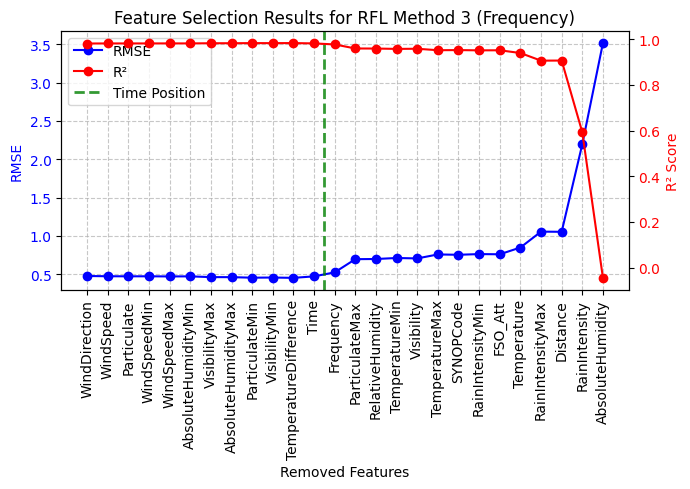

In [73]:
important_features_rfl_method2 = load_and_plot_method2_result('RFL', 'Frequency')

In [74]:
important_features_fso = ['AbsoluteHumidity',
 'Distance',
 'Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'TemperatureMin',
 'Time',
 'Visibility',
 'VisibilityMin']

In [75]:
train_idx, test_idx = train_test_split(processed_data.index, test_size=0.2, random_state=42)

In [76]:
#train test split
X_fso_method2, y_fso_method2 = gene_final_X_y(important_features_fso, 'FSO_Att')

x_train_fso,y_train_fso = X_fso_method2.loc[train_idx], y_fso_method2.loc[train_idx]
x_test_fso,y_test_fso = X_fso_method2.loc[test_idx], y_fso_method2.loc[test_idx]

fso_method2_tune = tune_random_forest(
    x_train_fso, 
    y_train_fso,
    cv=5,
    verbose=True
)

fso_method2_best_model = fso_method2_tune['final_model']

Start tuning...
Dataset size: (73103, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE | OOB mutualinfo
--------------------------------------------------------------------------------
         100 |      None |  0.957522 |  0.957522 |  0.806126 |  1.342302
         100 |        10 |  0.904458 |  0.904458 |  1.208980 |  1.019421
         100 |        20 |  0.956054 |  0.956054 |  0.819938 |  1.332135
         150 |      None |  0.958150 |  0.958150 |  0.800147 |  1.349192
         150 |        10 |  0.904543 |  0.904543 |  1.208441 |  1.020566
         150 |        20 |  0.956636 |  0.956636 |  0.814497 |  1.334763

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.958150
Best OOB R² Score: 0.958150
Best OOB RMSE: 0.800147
Best OOB mutualinfo: 1.349192


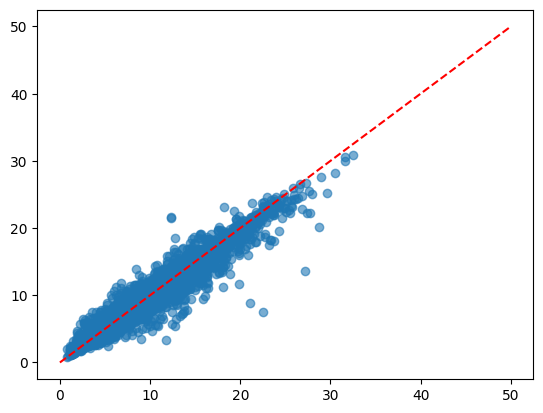

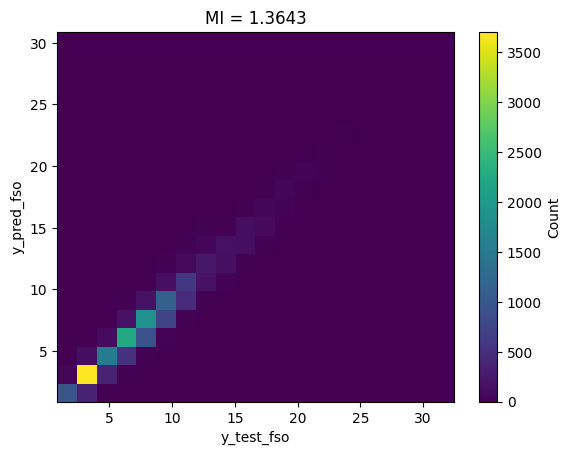

In [77]:
# predict on test set
y_pred_fso = fso_method2_best_model.predict(x_test_fso)
plt.scatter(y_test_fso, y_pred_fso, alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_test_fso, y_pred_fso, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_test_fso')      
plt.ylabel('y_pred_fso') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

In [78]:
important_features_rfl_method2_without_fso = ['AbsoluteHumidity',
 'Distance',
 'Frequency',
 'ParticulateMax',
 'RainIntensity',
 'RainIntensityMax',
 'RainIntensityMin',
 'RelativeHumidity',
 'SYNOPCode',
 'Temperature',
 'TemperatureMax',
 'Visibility']

In [79]:
#train test split
X_rfl_method2, y_rfl_method2 = gene_final_X_y(important_features_rfl_method2_without_fso, 'RFL_Att')

x_train_rfl_wo,y_train_rfl_wo = X_rfl_method2.loc[train_idx], y_rfl_method2.loc[train_idx]
x_test_rfl_wo,y_test_rfl_wo = X_rfl_method2.loc[test_idx], y_rfl_method2.loc[test_idx]

rfl_method2_tune_without_fso = tune_random_forest(
    x_train_rfl_wo, 
    y_train_rfl_wo,
    cv=5,
    verbose=True
)

rfl_method2_best_model_without_fso = rfl_method2_tune_without_fso['final_model']

Start tuning...
Dataset size: (73103, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE | OOB mutualinfo
--------------------------------------------------------------------------------
         100 |      None |  0.971943 |  0.971943 |  0.575890 |  1.016437
         100 |        10 |  0.958502 |  0.958502 |  0.700376 |  0.935811
         100 |        20 |  0.971814 |  0.971814 |  0.577213 |  1.011964
         150 |      None |  0.972440 |  0.972440 |  0.570767 |  1.021051
         150 |        10 |  0.958772 |  0.958772 |  0.698095 |  0.939736
         150 |        20 |  0.972279 |  0.972279 |  0.572430 |  1.012008

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.972440
Best OOB R² Score: 0.972440
Best OOB RMSE: 0.570767
Best OOB mutualinfo: 1.021051


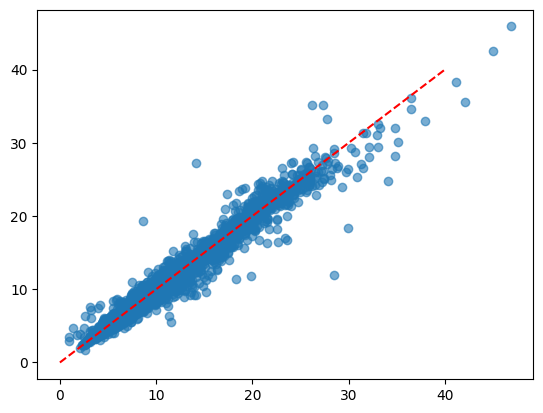

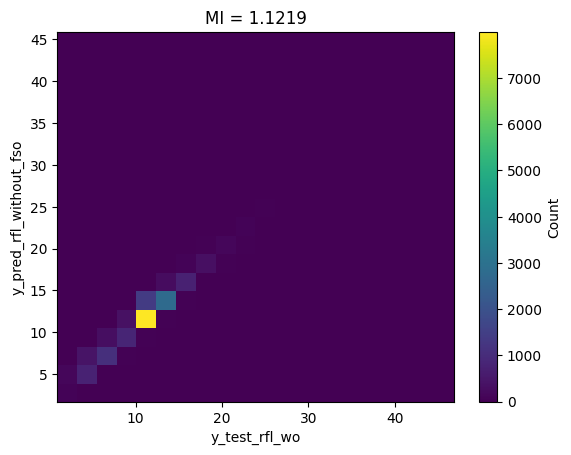

In [80]:
y_pred_rfl_without_fso = rfl_method2_best_model_without_fso.predict(x_test_rfl_wo)
plt.scatter(y_test_rfl_wo, y_pred_rfl_without_fso, alpha=0.6)
plt.plot([0, 40], [0, 40], color='red', linestyle='--')
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_test_rfl_wo, y_pred_rfl_without_fso, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_test_rfl_wo')      
plt.ylabel('y_pred_rfl_without_fso') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

In [81]:
#train test split
X_rfl_method2, y_rfl_method2 = gene_final_X_y(important_features_rfl_method2, 'RFL_Att')

x_train_rfl,y_train_rfl = X_rfl_method2.loc[train_idx], y_rfl_method2.loc[train_idx]
x_test_rfl,y_test_rfl = X_rfl_method2.loc[test_idx], y_rfl_method2.loc[test_idx]

rfl_method2_tune = tune_random_forest(
    x_train_rfl, 
    y_train_rfl,
    cv=5,
    verbose=True
)

rfl_method2_best_model = rfl_method2_tune['final_model']

Start tuning...
Dataset size: (73103, 14)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE | OOB mutualinfo
--------------------------------------------------------------------------------
         100 |      None |  0.974450 |  0.974450 |  0.549562 |  1.016107
         100 |        10 |  0.959709 |  0.959709 |  0.690115 |  0.948437
         100 |        20 |  0.974457 |  0.974457 |  0.549480 |  1.038614
         150 |      None |  0.975002 |  0.975002 |  0.543590 |  0.988724
         150 |        10 |  0.959929 |  0.959929 |  0.688233 |  0.947180
         150 |        20 |  0.975008 |  0.975008 |  0.543523 |  1.013987

Best result:
Best parameters: n_estimators=150, max_depth=20
Best OOB Score: 0.975008
Best OOB R² Score: 0.975008
Best OOB RMSE: 0.543523
Best OOB mutualinfo: 1.013987


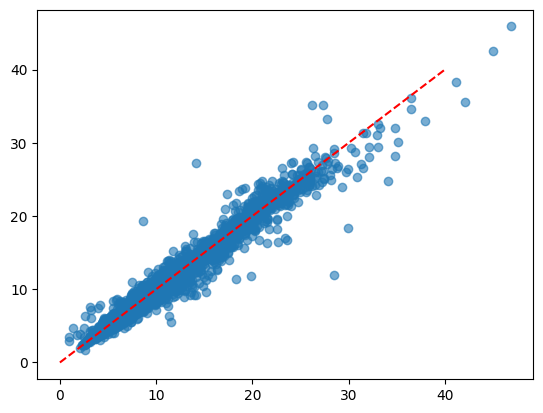

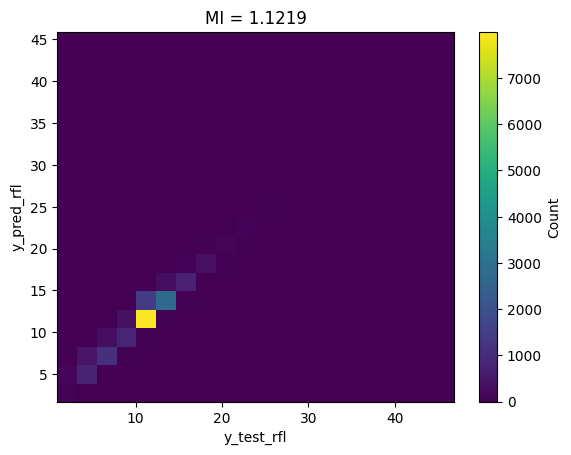

In [205]:
y_pred_rfl = rfl_method2_best_model.predict(x_test_rfl)
plt.scatter(y_test_rfl, y_pred_rfl, alpha=0.6)
plt.plot([0, 40], [0, 40], color='red', linestyle='--')
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_test_rfl, y_pred_rfl, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_test_rfl')      
plt.ylabel('y_pred_rfl') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

Pearson correlation coefficient: 0.087808


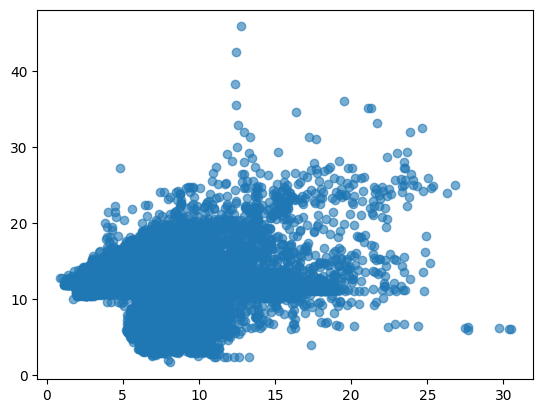

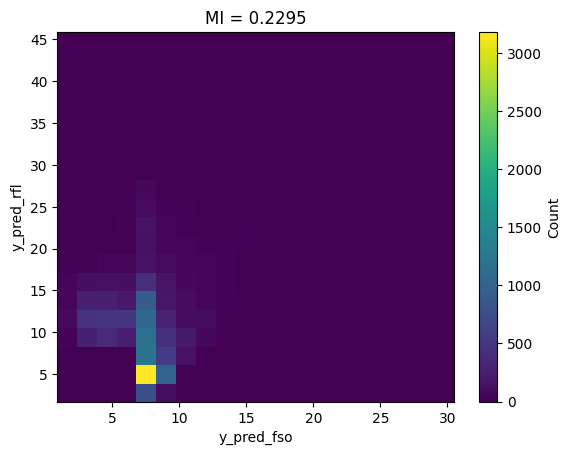

In [206]:
plt.scatter(y_pred_fso, y_pred_rfl, alpha=0.6)
#pcc
pcc = np.corrcoef(y_pred_fso, y_pred_rfl)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_fso, y_pred_rfl, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_pred_fso')      
plt.ylabel('y_pred_rfl') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

Pearson correlation coefficient: 0.087808


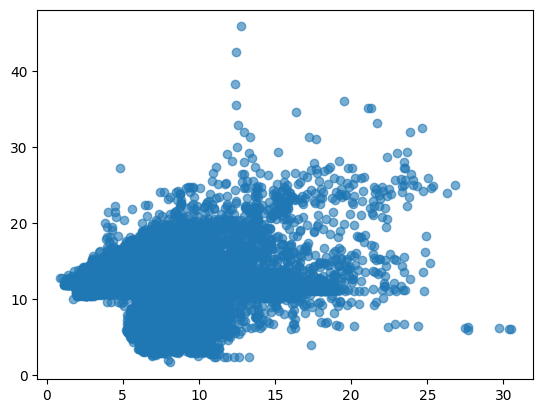

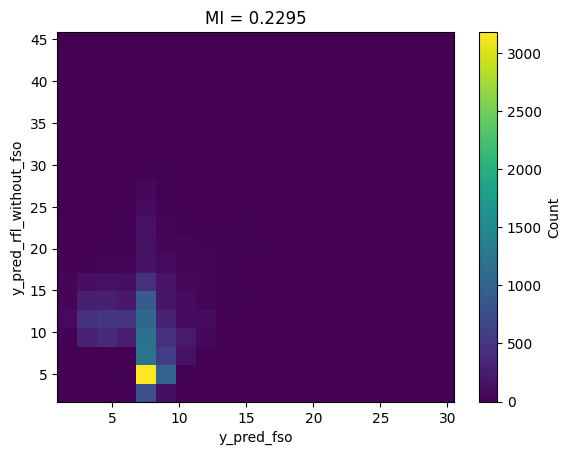

In [207]:
plt.scatter(y_pred_fso, y_pred_rfl_without_fso, alpha=0.6)
#pcc
pcc = np.corrcoef(y_pred_fso, y_pred_rfl_without_fso)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")
plt.show()

mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_fso, y_pred_rfl_without_fso, bins=20)
plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
           extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
plt.xlabel('y_pred_fso')      
plt.ylabel('y_pred_rfl_without_fso') 
plt.title(f"MI = {mutualinfo:.4f}")
plt.colorbar(label='Count')
plt.show()

In [208]:
from sklearn.metrics import mean_squared_error

In [209]:
_,synop_code = gene_final_X_y(important_features_fso, 'SYNOPCode')

In [210]:
synop_code_test = synop_code.loc[test_idx]

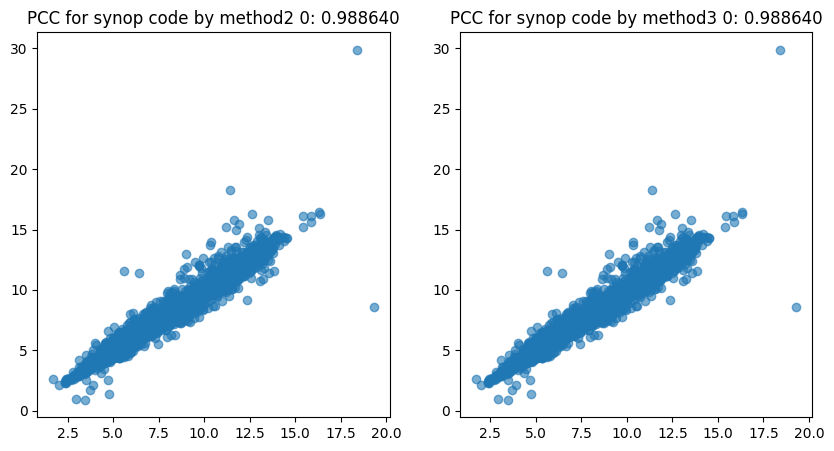

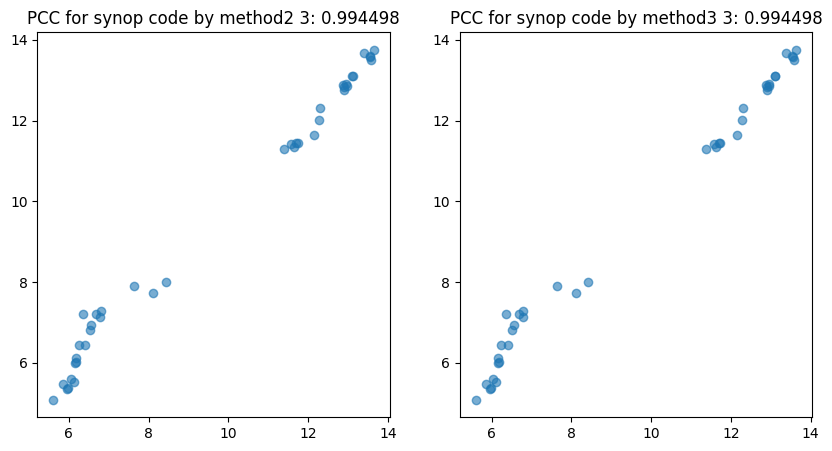

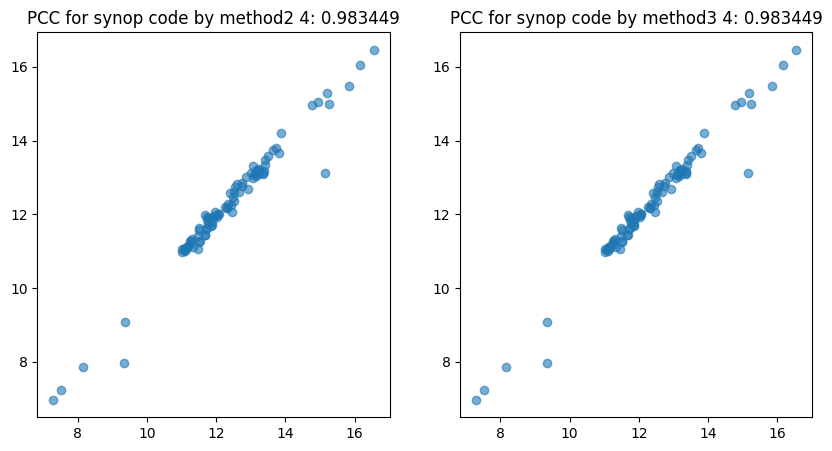

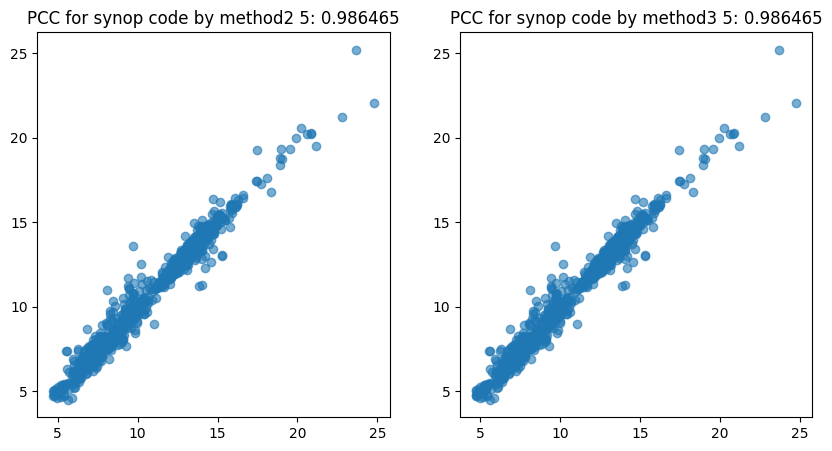

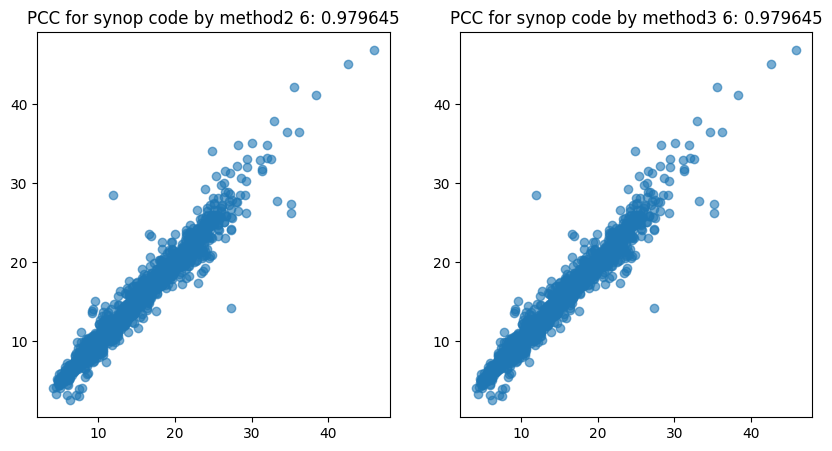

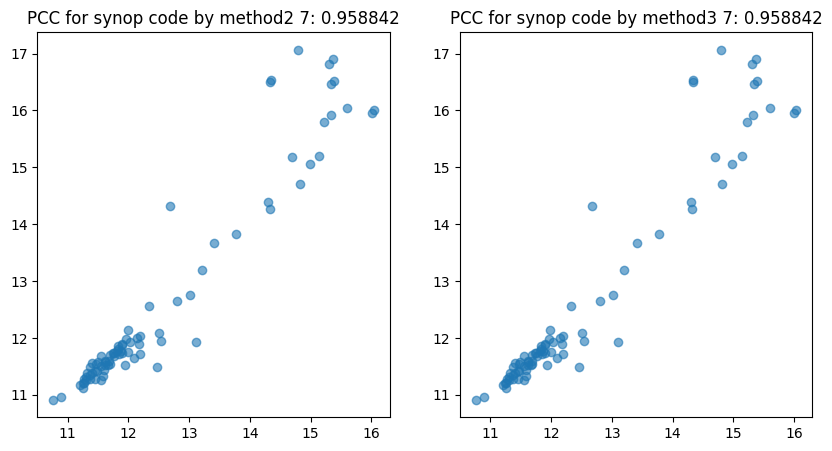

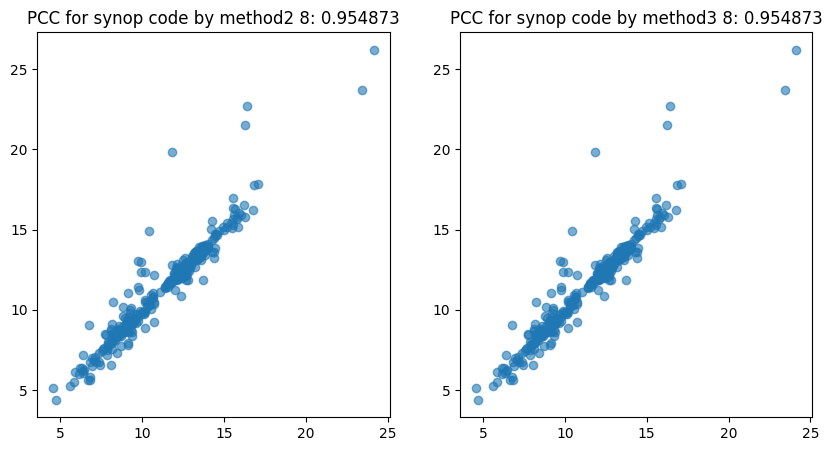

In [211]:
data = []
for sy in [0,3,4,5,6,7,8]:
    data_sy = []
    data_sy.append(sy)
    idx = synop_code_test==sy
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(y_pred_rfl_without_fso[idx], y_test_rfl[idx], alpha=0.6)
    #pcc
    pcc = np.corrcoef(y_pred_rfl_without_fso[idx], y_test_rfl[idx])[0, 1]
    mse = mean_squared_error(y_pred_rfl_without_fso[idx], y_test_rfl[idx])
    rmse = np.sqrt(mse)
    plt.title(f"PCC for synop code by method2 {sy}: {pcc:.6f}")
    data_sy.append(float(pcc))
    data_sy.append(float(mse))
    data_sy.append(float(rmse))
    plt.subplot(122)
    plt.scatter(y_pred_rfl[idx], y_test_rfl[idx], alpha=0.6)
    #pcc
    pcc = np.corrcoef(y_pred_rfl[idx], y_test_rfl[idx])[0, 1]
    mse = mean_squared_error(y_pred_rfl[idx], y_test_rfl[idx])
    rmse = np.sqrt(mse)
    data_sy.append(float(pcc))
    data_sy.append(float(mse))
    data_sy.append(float(rmse))
    plt.title(f"PCC for synop code by method3 {sy}: {pcc:.6f}")
    plt.show()
    data.append(data_sy)

In [101]:
rfl_0 = pd.DataFrame(data, columns=['SYNOPCode', 'pcc_method2','MSE_method2', 'RMSE_method2', 'pcc_method3', 'MSE_method3', 'RMSE_method3'])
rfl_0

SYNOPCode  pcc_method2  MSE_method2  RMSE_method2  pcc_method3  \
0          0     0.988640     0.145762      0.381788     0.989789   
1          3     0.994498     0.115157      0.339347     0.995510   
2          4     0.983449     0.092359      0.303906     0.990055   
3          5     0.986465     0.221441      0.470575     0.985605   
4          6     0.979645     0.660779      0.812883     0.982161   
5          7     0.958842     0.367569      0.606275     0.969978   
6          8     0.954873     0.736618      0.858264     0.953537   

   MSE_method3  RMSE_method3  
0     0.131136      0.362127  
1     0.095028      0.308266  
2     0.057647      0.240097  
3     0.234812      0.484575  
4     0.580720      0.762050  
5     0.283608      0.532549  
6     0.758551      0.870948

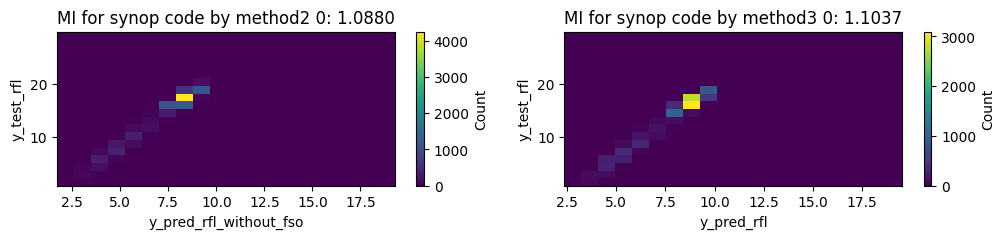

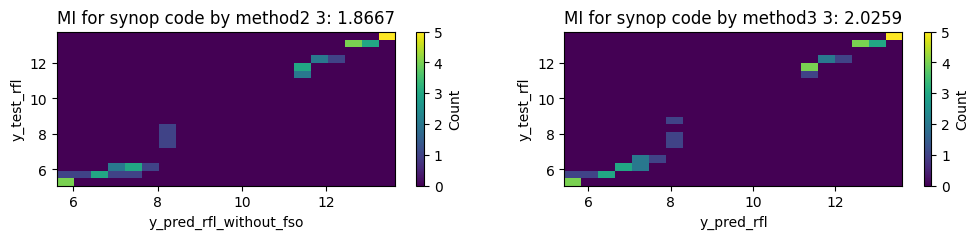

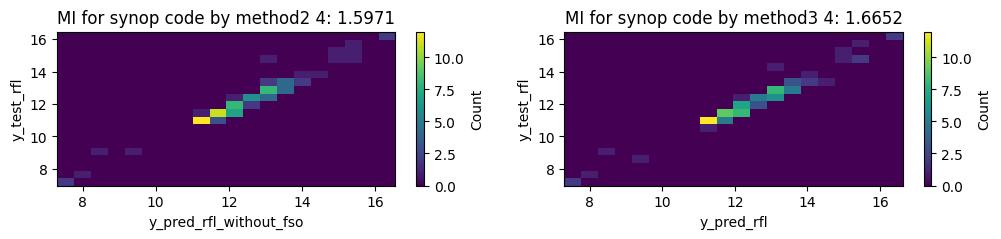

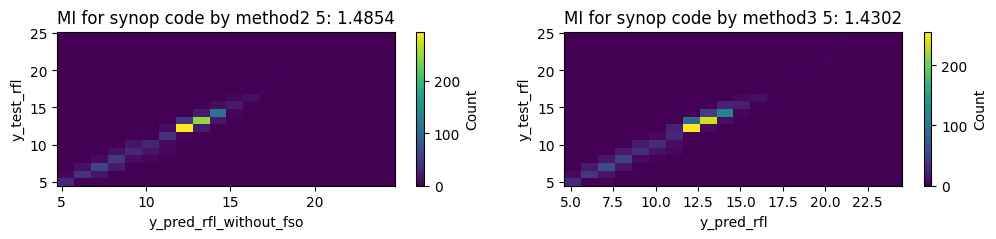

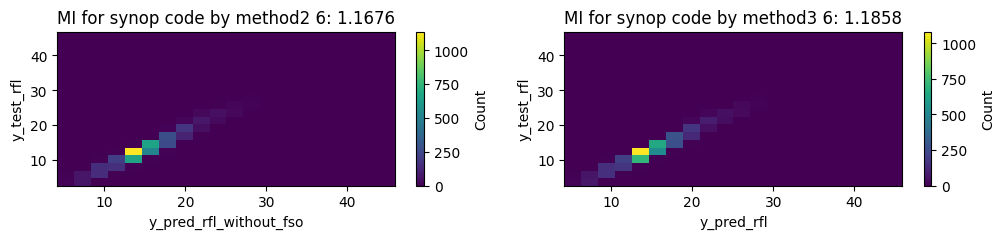

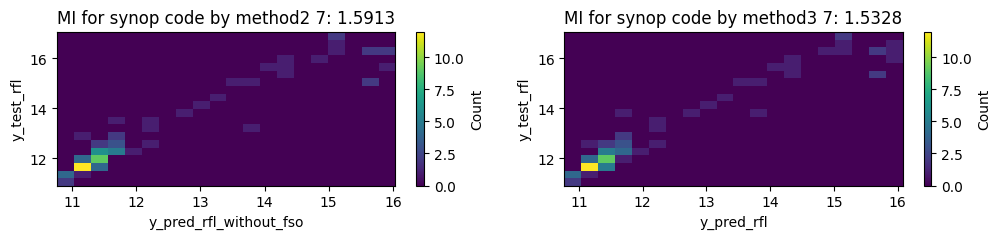

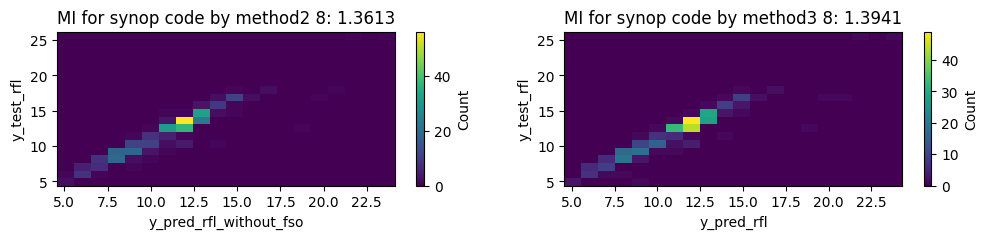

In [102]:
data = []
for sy in [0,3,4,5,6,7,8]:
    data_sy = []
    data_sy.append(sy)
    idx = synop_code_test==sy
    plt.figure(figsize=(12,2))
    plt.subplot(121)
    mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_rfl_without_fso[idx], y_test_rfl[idx], bins=20)
    plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
               extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
    plt.xlabel(f'y_pred_rfl_without_fso')      
    plt.ylabel(f'y_test_rfl')
    plt.title(f"MI for synop code by method2 {sy}: {mutualinfo:.4f}")
    plt.colorbar(label='Count')
    data_sy.append(float(mutualinfo))
    
    plt.subplot(122)
    mutualinfo, cm ,y_edges, ypred_edges= calculate_mutual_info_continuous_discretize(y_pred_rfl[idx], y_test_rfl[idx], bins=20)
    plt.imshow(cm, origin='lower', cmap='viridis', aspect='auto',
               extent=[y_edges[0], y_edges[-1], ypred_edges[0], ypred_edges[-1]])
    plt.xlabel(f'y_pred_rfl')      
    plt.ylabel(f'y_test_rfl')
    plt.title(f"MI for synop code by method3 {sy}: {mutualinfo:.4f}")
    plt.colorbar(label='Count')
    data_sy.append(float(mutualinfo))
    plt.show()
    data.append(data_sy)

In [103]:
rfl_MI = pd.DataFrame(data, columns=['SYNOPCode', 'MI_method2', 'MI_method3'])
rfl_MI

SYNOPCode  MI_method2  MI_method3
0          0    1.087995    1.103747
1          3    1.866744    2.025944
2          4    1.597111    1.665177
3          5    1.485444    1.430205
4          6    1.167616    1.185766
5          7    1.591304    1.532761
6          8    1.361259    1.394144

In [105]:
rfl = pd.concat([rfl_0,rfl_MI],axis=1)
rfl

SYNOPCode  pcc_method2  MSE_method2  RMSE_method2  pcc_method3  \
0          0     0.988640     0.145762      0.381788     0.989789   
1          3     0.994498     0.115157      0.339347     0.995510   
2          4     0.983449     0.092359      0.303906     0.990055   
3          5     0.986465     0.221441      0.470575     0.985605   
4          6     0.979645     0.660779      0.812883     0.982161   
5          7     0.958842     0.367569      0.606275     0.969978   
6          8     0.954873     0.736618      0.858264     0.953537   

   MSE_method3  RMSE_method3  SYNOPCode  MI_method2  MI_method3  
0     0.131136      0.362127          0    1.087995    1.103747  
1     0.095028      0.308266          3    1.866744    2.025944  
2     0.057647      0.240097          4    1.597111    1.665177  
3     0.234812      0.484575          5    1.485444    1.430205  
4     0.580720      0.762050          6    1.167616    1.185766  
5     0.283608      0.532549          7    1.591304    1.532761  
6     0.758551      0.870948          8    1.361259    1.394144

In [159]:
rfl.columns=["synop","pcc_rfl_wo","mse_rfl_wo","rmse_rfl_wo","pcc_rfl_with","mse_rfl_with","rmse_rfl_with","synop","MI_rfl_wo","MI_rfl_with",]
rfl

synop  pcc_rfl_wo  mse_rfl_wo  rmse_rfl_wo  pcc_rfl_with  mse_rfl_with  \
0      0    0.988640    0.145762     0.381788      0.989789      0.131136   
1      3    0.994498    0.115157     0.339347      0.995510      0.095028   
2      4    0.983449    0.092359     0.303906      0.990055      0.057647   
3      5    0.986465    0.221441     0.470575      0.985605      0.234812   
4      6    0.979645    0.660779     0.812883      0.982161      0.580720   
5      7    0.958842    0.367569     0.606275      0.969978      0.283608   
6      8    0.954873    0.736618     0.858264      0.953537      0.758551   

   rmse_rfl_with  synop  MI_rfl_wo  MI_rfl_with  
0       0.362127      0   1.087995     1.103747  
1       0.308266      3   1.866744     2.025944  
2       0.240097      4   1.597111     1.665177  
3       0.484575      5   1.485444     1.430205  
4       0.762050      6   1.167616     1.185766  
5       0.532549      7   1.591304     1.532761  
6       0.870948      8   1.361259     1.394144

In [160]:
fso.columns=["synop","pcc_fso_wo","mse_fso_wo","rmse_fso_wo","pcc_fso_with","mse_fso_with","rmse_fso_with","synop","MI_fso_wo","MI_fso_with",]
fso

synop  pcc_fso_wo  mse_fso_wo  rmse_fso_wo  pcc_fso_with  mse_fso_with  \
0      0    0.974229    0.610673     0.781456      0.972476      0.651897   
1      3    0.996127    0.745598     0.863480      0.983376      3.089765   
2      4    0.982601    0.509831     0.714025      0.981296      0.544978   
3      5    0.979009    0.520133     0.721203      0.977406      0.561216   
4      6    0.984264    0.569498     0.754651      0.983493      0.597434   
5      7    0.985443    1.258490     1.121824      0.986329      1.256161   
6      8    0.980677    0.559565     0.748041      0.981195      0.547763   

   rmse_fso_with  synop  MI_fso_wo  MI_fso_with  
0       0.807402      0   1.254522     1.229785  
1       1.757773      3   2.260933     2.219512  
2       0.738226      4   1.807338     1.784093  
3       0.749144      5   1.504709     1.473426  
4       0.772938      6   1.519745     1.515235  
5       1.120786      7   1.922635     1.915926  
6       0.740110      8   1.711149     1.674869

In [162]:
dat = pd.concat([rfl,fso],axis=1)
dat

synop  pcc_rfl_wo  mse_rfl_wo  rmse_rfl_wo  pcc_rfl_with  mse_rfl_with  \
0      0    0.988640    0.145762     0.381788      0.989789      0.131136   
1      3    0.994498    0.115157     0.339347      0.995510      0.095028   
2      4    0.983449    0.092359     0.303906      0.990055      0.057647   
3      5    0.986465    0.221441     0.470575      0.985605      0.234812   
4      6    0.979645    0.660779     0.812883      0.982161      0.580720   
5      7    0.958842    0.367569     0.606275      0.969978      0.283608   
6      8    0.954873    0.736618     0.858264      0.953537      0.758551   

   rmse_rfl_with  synop  MI_rfl_wo  MI_rfl_with  synop  pcc_fso_wo  \
0       0.362127      0   1.087995     1.103747      0    0.974229   
1       0.308266      3   1.866744     2.025944      3    0.996127   
2       0.240097      4   1.597111     1.665177      4    0.982601   
3       0.484575      5   1.485444     1.430205      5    0.979009   
4       0.762050      6   1.167616     1.185766      6    0.984264   
5       0.532549      7   1.591304     1.532761      7    0.985443   
6       0.870948      8   1.361259     1.394144      8    0.980677   

   mse_fso_wo  rmse_fso_wo  pcc_fso_with  mse_fso_with  rmse_fso_with  synop  \
0    0.610673     0.781456      0.972476      0.651897       0.807402      0   
1    0.745598     0.863480      0.983376      3.089765       1.757773      3   
2    0.509831     0.714025      0.981296      0.544978       0.738226      4   
3    0.520133     0.721203      0.977406      0.561216       0.749144      5   
4    0.569498     0.754651      0.983493      0.597434       0.772938      6   
5    1.258490     1.121824      0.986329      1.256161       1.120786      7   
6    0.559565     0.748041      0.981195      0.547763       0.740110      8   

   MI_fso_wo  MI_fso_with  
0   1.254522     1.229785  
1   2.260933     2.219512  
2   1.807338     1.784093  
3   1.504709     1.473426  
4   1.519745     1.515235  
5   1.922635     1.915926  
6   1.711149     1.674869

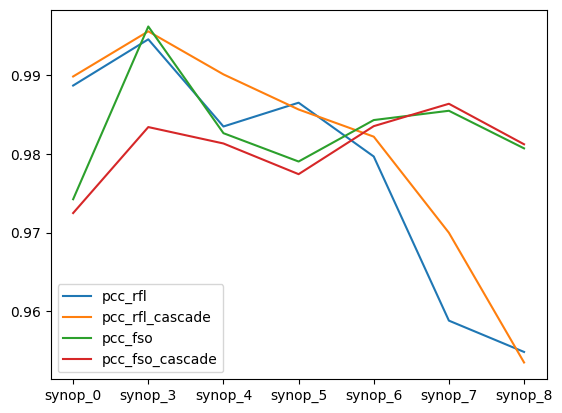

In [189]:
xticks = ["synop_0","synop_3","synop_4","synop_5","synop_6","synop_7","synop_8"]
plt.plot(xticks,dat["pcc_rfl_wo"],label="pcc_rfl")
plt.plot(xticks,dat["pcc_rfl_with"],label="pcc_rfl_cascade")
plt.plot(xticks,dat["pcc_fso_wo"],label="pcc_fso")
plt.plot(xticks,dat["pcc_fso_with"],label="pcc_fso_cascade")
plt.legend()

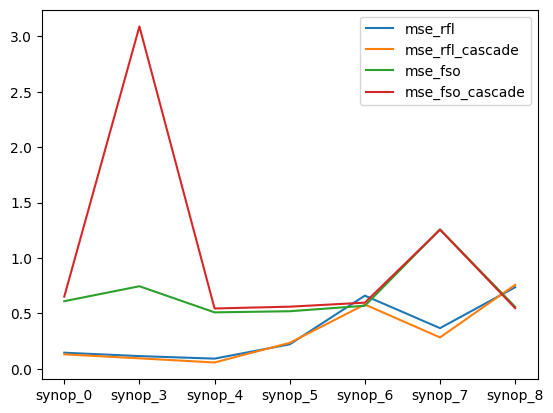

In [196]:
plt.plot(xticks,dat["mse_rfl_wo"],label="mse_rfl")
plt.plot(xticks,dat["mse_rfl_with"],label="mse_rfl_cascade")
plt.plot(xticks,dat["mse_fso_wo"],label="mse_fso")
plt.plot(xticks,dat["mse_fso_with"],label="mse_fso_cascade")
plt.legend()

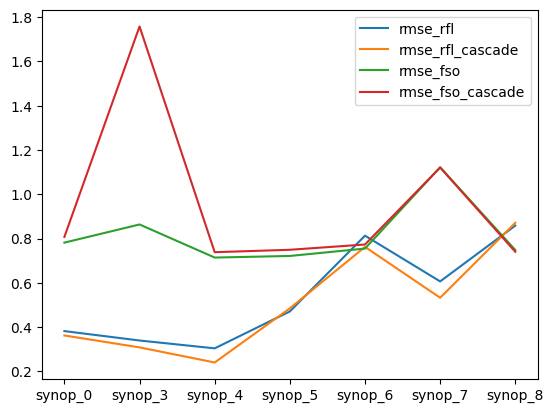

In [195]:
plt.plot(xticks,dat["rmse_rfl_wo"],label="rmse_rfl")
plt.plot(xticks,dat["rmse_rfl_with"],label="rmse_rfl_cascade")
plt.plot(xticks,dat["rmse_fso_wo"],label="rmse_fso")
plt.plot(xticks,dat["rmse_fso_with"],label="rmse_fso_cascade")
plt.legend()

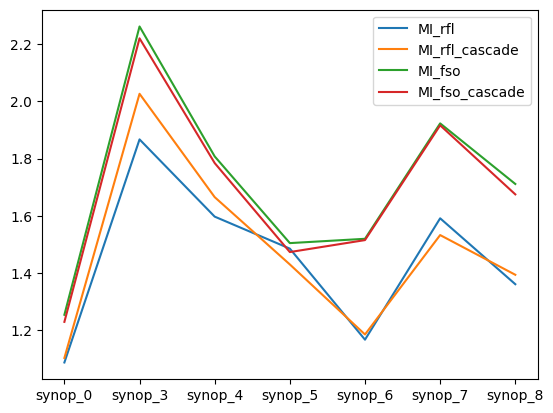

In [194]:
plt.plot(xticks,dat["MI_rfl_wo"],label="MI_rfl")
plt.plot(xticks,dat["MI_rfl_with"],label="MI_rfl_cascade")
plt.plot(xticks,dat["MI_fso_wo"],label="MI_fso")
plt.plot(xticks,dat["MI_fso_with"],label="MI_fso_cascade")
plt.legend()